In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from pandas.api.types import is_numeric_dtype
from sklearn.metrics import precision_recall_curve
import catboost as cb
import gc
from sklearn.metrics import auc
import os

In [2]:
all_data = {}

In [3]:
# Obtaining directory of test datasets
d = '/Users/admin/BT4012/Project/Test'
test_files = os.listdir(d)
test_files = sorted(test_files)
test_files = [os.path.join(d, x) for x in test_files]
test_files.pop(0)
test_files

['/Users/admin/BT4012/Project/Test/test1.csv',
 '/Users/admin/BT4012/Project/Test/test2.csv',
 '/Users/admin/BT4012/Project/Test/test3.csv',
 '/Users/admin/BT4012/Project/Test/test4.csv',
 '/Users/admin/BT4012/Project/Test/test5.csv']

In [4]:
# Obtaining and Storing directory of train datasets for ROS-RUS 50
d = '/Users/admin/BT4012/Project/ROS_RUS_50'
train_files =  os.listdir(d)
train_files = sorted(train_files)
train_files = [os.path.join(d, x) for x in train_files]
all_data['ROS_RUS_50'] = train_files

In [5]:
# Obtaining and Storing directory of train datasets for ROS-RUS 75
d = '/Users/admin/BT4012/Project/ROS_RUS_75'
train_files =  os.listdir(d)
train_files = sorted(train_files)
train_files = [os.path.join(d, x) for x in train_files]
all_data['ROS_RUS_75'] = train_files

In [6]:
# Obtaining and Storing directory of train datasets for ROS-RUS 90
d = '/Users/admin/BT4012/Project/ROS_RUS_90'
train_files =  os.listdir(d)
train_files = sorted(train_files)
train_files = [os.path.join(d, x) for x in train_files]
all_data['ROS_RUS_90'] = train_files

In [7]:
all_data

{'ROS_RUS_50': ['/Users/admin/BT4012/Project/ROS_RUS_50/ROS_RUS_0.5_1.csv',
  '/Users/admin/BT4012/Project/ROS_RUS_50/ROS_RUS_0.5_2.csv',
  '/Users/admin/BT4012/Project/ROS_RUS_50/ROS_RUS_0.5_3.csv',
  '/Users/admin/BT4012/Project/ROS_RUS_50/ROS_RUS_0.5_4.csv',
  '/Users/admin/BT4012/Project/ROS_RUS_50/ROS_RUS_0.5_5.csv'],
 'ROS_RUS_75': ['/Users/admin/BT4012/Project/ROS_RUS_75/ROS_RUS_0.25_1.csv',
  '/Users/admin/BT4012/Project/ROS_RUS_75/ROS_RUS_0.25_2.csv',
  '/Users/admin/BT4012/Project/ROS_RUS_75/ROS_RUS_0.25_3.csv',
  '/Users/admin/BT4012/Project/ROS_RUS_75/ROS_RUS_0.25_4.csv',
  '/Users/admin/BT4012/Project/ROS_RUS_75/ROS_RUS_0.25_5.csv'],
 'ROS_RUS_90': ['/Users/admin/BT4012/Project/ROS_RUS_90/ROS_RUS_0.1_1.csv',
  '/Users/admin/BT4012/Project/ROS_RUS_90/ROS_RUS_0.1_2.csv',
  '/Users/admin/BT4012/Project/ROS_RUS_90/ROS_RUS_0.1_3.csv',
  '/Users/admin/BT4012/Project/ROS_RUS_90/ROS_RUS_0.1_4.csv',
  '/Users/admin/BT4012/Project/ROS_RUS_90/ROS_RUS_0.1_5.csv']}

## Basic Preprocessing Functions

## Getting categorical columns

In [8]:
def get_categorical_indices(X):
    cats = []
    for col in X.columns:
        if is_numeric_dtype(X[col]):
            pass
        else:
            cats.append(col)
    cat_indices = []
    for col in cats:
        cat_indices.append(X.columns.get_loc(col))
    return cat_indices

## Preprocess the categorical features

1. Removing nulls 
2. Processing Categorical columns to "Category" data type

In [9]:
def process_cat(x_train):
    cats = []
    for col in x_train.columns:
        if is_numeric_dtype(x_train[col]):
            pass
        else:
            cats.append(col)
    for col in cats:
        x_train[col] = x_train[col].fillna('Nan')
        x_train[col] = x_train[col].astype('category')
        
    return x_train


In [10]:
def calculate_scores(y_test_proba, y_test):
    precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)

    auc_precision_recall = auc(recall, precision)
    roc_auc_score = metrics.roc_auc_score(y_test, y_test_proba)
    
#     print("Confusion Matrix: \n%s" % str(conf_matrix))
#     print("\nAccuracy: %.4f" % accuracy_score)
#     print("\nAU-PRC: %.4f" % auc_precision_recall)
#     print("\nAU-ROC: %.4f" % roc_auc_score)
#     print("\nF1 Score: %.4f" % f1_score)

    return {
        "roc_auc_score": roc_auc_score,
        "auc_precision_recall": auc_precision_recall,
    }

## Build Model and get scores

In [11]:
results = {}

In [13]:
# Looping through the different Sampling ratios
for method, dfs in all_data.items():
    print(method)
    print(dfs)

    total_auPRC = 0
    total_auROC = 0
    reports = []
        
    # Looping through the 5 fold training data
    for i in range(0, len(dfs)):
        print(i)

        # Reading data
        train = pd.read_csv(dfs[i], index_col = False)
        test = pd.read_csv(test_files[i], index_col = False)

        #drop irrelevant columns
        x_train = train.drop(['Unnamed: 0','Rndrng_NPI', 'Tot_Srvcs','Fraud'], axis = 1)
        y_train = train[['Fraud']]

        x_test = test.drop(['Unnamed: 0','Rndrng_NPI', 'Tot_Srvcs', 'Fraud'], axis = 1)
        y_test = test[['Fraud']]

        # process categorical data
        categorical_indices = get_categorical_indices(x_train)
        x_train = process_cat(x_train)
        x_test = process_cat(x_test)

        model = cb.CatBoostClassifier(task_type = 'CPU')
        model.fit(x_train, y_train, cat_features=categorical_indices)

        y_test_proba = model.predict_proba(x_test)[:, 1]

        #calculate auPRC
        precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)
        auc_precision_recall = auc(recall, precision)
        total_auPRC+= auc_precision_recall

        #calculate auROC
        roc_auc_score = metrics.roc_auc_score(y_test, y_test_proba)
        total_auROC += roc_auc_score

        #add report to the ls of reports
        reports.append(calculate_scores(y_test_proba, y_test))
    
    mean_auPRC = total_auPRC/len(dfs)
    mean_auROC = total_auROC/len(dfs)
    
    print(mean_auPRC)
    print(mean_auROC)
    
    results[method] = (mean_auPRC, mean_auROC)

ROS_RUS_50
['/Users/admin/BT4012/Project/ROS_RUS_50/ROS_RUS_0.5_1.csv', '/Users/admin/BT4012/Project/ROS_RUS_50/ROS_RUS_0.5_2.csv', '/Users/admin/BT4012/Project/ROS_RUS_50/ROS_RUS_0.5_3.csv', '/Users/admin/BT4012/Project/ROS_RUS_50/ROS_RUS_0.5_4.csv', '/Users/admin/BT4012/Project/ROS_RUS_50/ROS_RUS_0.5_5.csv']
0
Learning rate set to 0.158143
0:	learn: 0.3835998	total: 617ms	remaining: 10m 16s
1:	learn: 0.2611244	total: 1.05s	remaining: 8m 42s
2:	learn: 0.1902032	total: 1.36s	remaining: 7m 33s
3:	learn: 0.1115137	total: 1.85s	remaining: 7m 40s
4:	learn: 0.0757324	total: 2.28s	remaining: 7m 34s
5:	learn: 0.0582600	total: 2.61s	remaining: 7m 12s
6:	learn: 0.0487682	total: 2.9s	remaining: 6m 50s
7:	learn: 0.0433689	total: 3.17s	remaining: 6m 33s
8:	learn: 0.0392961	total: 3.49s	remaining: 6m 24s
9:	learn: 0.0367817	total: 3.79s	remaining: 6m 15s
10:	learn: 0.0345850	total: 4.06s	remaining: 6m 5s
11:	learn: 0.0328534	total: 4.42s	remaining: 6m 3s
12:	learn: 0.0310991	total: 4.82s	remaining:

152:	learn: 0.0077148	total: 58.2s	remaining: 5m 22s
153:	learn: 0.0076624	total: 58.6s	remaining: 5m 22s
154:	learn: 0.0075804	total: 59.1s	remaining: 5m 21s
155:	learn: 0.0075804	total: 59.3s	remaining: 5m 21s
156:	learn: 0.0075632	total: 59.7s	remaining: 5m 20s
157:	learn: 0.0075198	total: 1m	remaining: 5m 20s
158:	learn: 0.0075088	total: 1m	remaining: 5m 19s
159:	learn: 0.0075088	total: 1m	remaining: 5m 18s
160:	learn: 0.0074648	total: 1m 1s	remaining: 5m 18s
161:	learn: 0.0074361	total: 1m 1s	remaining: 5m 17s
162:	learn: 0.0071615	total: 1m 1s	remaining: 5m 18s
163:	learn: 0.0066716	total: 1m 2s	remaining: 5m 18s
164:	learn: 0.0066716	total: 1m 2s	remaining: 5m 18s
165:	learn: 0.0066410	total: 1m 3s	remaining: 5m 17s
166:	learn: 0.0066227	total: 1m 3s	remaining: 5m 17s
167:	learn: 0.0065960	total: 1m 4s	remaining: 5m 16s
168:	learn: 0.0065503	total: 1m 4s	remaining: 5m 16s
169:	learn: 0.0064797	total: 1m 4s	remaining: 5m 16s
170:	learn: 0.0064444	total: 1m 5s	remaining: 5m 16s
17

306:	learn: 0.0045862	total: 1m 49s	remaining: 4m 6s
307:	learn: 0.0045862	total: 1m 49s	remaining: 4m 6s
308:	learn: 0.0045861	total: 1m 50s	remaining: 4m 6s
309:	learn: 0.0045861	total: 1m 50s	remaining: 4m 5s
310:	learn: 0.0045861	total: 1m 50s	remaining: 4m 4s
311:	learn: 0.0045861	total: 1m 50s	remaining: 4m 4s
312:	learn: 0.0045861	total: 1m 51s	remaining: 4m 3s
313:	learn: 0.0045861	total: 1m 51s	remaining: 4m 3s
314:	learn: 0.0045861	total: 1m 51s	remaining: 4m 2s
315:	learn: 0.0045861	total: 1m 51s	remaining: 4m 1s
316:	learn: 0.0045861	total: 1m 51s	remaining: 4m 1s
317:	learn: 0.0045861	total: 1m 52s	remaining: 4m
318:	learn: 0.0045861	total: 1m 52s	remaining: 4m
319:	learn: 0.0045861	total: 1m 52s	remaining: 3m 59s
320:	learn: 0.0045861	total: 1m 52s	remaining: 3m 58s
321:	learn: 0.0045860	total: 1m 53s	remaining: 3m 58s
322:	learn: 0.0045860	total: 1m 53s	remaining: 3m 57s
323:	learn: 0.0045860	total: 1m 53s	remaining: 3m 57s
324:	learn: 0.0045860	total: 1m 53s	remaining: 

460:	learn: 0.0042992	total: 2m 30s	remaining: 2m 55s
461:	learn: 0.0042992	total: 2m 30s	remaining: 2m 55s
462:	learn: 0.0042992	total: 2m 30s	remaining: 2m 55s
463:	learn: 0.0042991	total: 2m 31s	remaining: 2m 54s
464:	learn: 0.0042991	total: 2m 31s	remaining: 2m 54s
465:	learn: 0.0042991	total: 2m 31s	remaining: 2m 53s
466:	learn: 0.0042991	total: 2m 31s	remaining: 2m 53s
467:	learn: 0.0042991	total: 2m 32s	remaining: 2m 52s
468:	learn: 0.0042991	total: 2m 32s	remaining: 2m 52s
469:	learn: 0.0042991	total: 2m 32s	remaining: 2m 51s
470:	learn: 0.0042991	total: 2m 32s	remaining: 2m 51s
471:	learn: 0.0042991	total: 2m 32s	remaining: 2m 51s
472:	learn: 0.0042991	total: 2m 33s	remaining: 2m 50s
473:	learn: 0.0042991	total: 2m 33s	remaining: 2m 50s
474:	learn: 0.0042991	total: 2m 33s	remaining: 2m 49s
475:	learn: 0.0042991	total: 2m 33s	remaining: 2m 49s
476:	learn: 0.0042991	total: 2m 34s	remaining: 2m 49s
477:	learn: 0.0042990	total: 2m 34s	remaining: 2m 48s
478:	learn: 0.0042990	total:

614:	learn: 0.0042984	total: 3m 7s	remaining: 1m 57s
615:	learn: 0.0042984	total: 3m 8s	remaining: 1m 57s
616:	learn: 0.0042984	total: 3m 8s	remaining: 1m 56s
617:	learn: 0.0042984	total: 3m 8s	remaining: 1m 56s
618:	learn: 0.0042984	total: 3m 8s	remaining: 1m 56s
619:	learn: 0.0042984	total: 3m 9s	remaining: 1m 55s
620:	learn: 0.0042984	total: 3m 9s	remaining: 1m 55s
621:	learn: 0.0042983	total: 3m 9s	remaining: 1m 55s
622:	learn: 0.0042983	total: 3m 9s	remaining: 1m 54s
623:	learn: 0.0042983	total: 3m 10s	remaining: 1m 54s
624:	learn: 0.0042983	total: 3m 10s	remaining: 1m 54s
625:	learn: 0.0042695	total: 3m 10s	remaining: 1m 54s
626:	learn: 0.0042695	total: 3m 11s	remaining: 1m 53s
627:	learn: 0.0042695	total: 3m 11s	remaining: 1m 53s
628:	learn: 0.0042695	total: 3m 11s	remaining: 1m 53s
629:	learn: 0.0042695	total: 3m 12s	remaining: 1m 52s
630:	learn: 0.0042695	total: 3m 12s	remaining: 1m 52s
631:	learn: 0.0042695	total: 3m 12s	remaining: 1m 52s
632:	learn: 0.0042695	total: 3m 12s	r

766:	learn: 0.0042691	total: 3m 43s	remaining: 1m 7s
767:	learn: 0.0042691	total: 3m 43s	remaining: 1m 7s
768:	learn: 0.0042691	total: 3m 43s	remaining: 1m 7s
769:	learn: 0.0042691	total: 3m 43s	remaining: 1m 6s
770:	learn: 0.0042691	total: 3m 44s	remaining: 1m 6s
771:	learn: 0.0042691	total: 3m 44s	remaining: 1m 6s
772:	learn: 0.0042691	total: 3m 44s	remaining: 1m 5s
773:	learn: 0.0042691	total: 3m 44s	remaining: 1m 5s
774:	learn: 0.0042691	total: 3m 45s	remaining: 1m 5s
775:	learn: 0.0042691	total: 3m 45s	remaining: 1m 5s
776:	learn: 0.0042691	total: 3m 45s	remaining: 1m 4s
777:	learn: 0.0042691	total: 3m 45s	remaining: 1m 4s
778:	learn: 0.0042691	total: 3m 45s	remaining: 1m 4s
779:	learn: 0.0042691	total: 3m 46s	remaining: 1m 3s
780:	learn: 0.0042691	total: 3m 46s	remaining: 1m 3s
781:	learn: 0.0042691	total: 3m 46s	remaining: 1m 3s
782:	learn: 0.0042691	total: 3m 46s	remaining: 1m 2s
783:	learn: 0.0042691	total: 3m 46s	remaining: 1m 2s
784:	learn: 0.0042691	total: 3m 47s	remaining:

923:	learn: 0.0042686	total: 4m 18s	remaining: 21.3s
924:	learn: 0.0042686	total: 4m 18s	remaining: 21s
925:	learn: 0.0042686	total: 4m 18s	remaining: 20.7s
926:	learn: 0.0042686	total: 4m 19s	remaining: 20.4s
927:	learn: 0.0042686	total: 4m 19s	remaining: 20.1s
928:	learn: 0.0042686	total: 4m 19s	remaining: 19.8s
929:	learn: 0.0042686	total: 4m 19s	remaining: 19.5s
930:	learn: 0.0042686	total: 4m 19s	remaining: 19.3s
931:	learn: 0.0042686	total: 4m 20s	remaining: 19s
932:	learn: 0.0042686	total: 4m 20s	remaining: 18.7s
933:	learn: 0.0042686	total: 4m 20s	remaining: 18.4s
934:	learn: 0.0042686	total: 4m 20s	remaining: 18.1s
935:	learn: 0.0042686	total: 4m 21s	remaining: 17.9s
936:	learn: 0.0042686	total: 4m 21s	remaining: 17.6s
937:	learn: 0.0042686	total: 4m 21s	remaining: 17.3s
938:	learn: 0.0042686	total: 4m 21s	remaining: 17s
939:	learn: 0.0042686	total: 4m 21s	remaining: 16.7s
940:	learn: 0.0042686	total: 4m 22s	remaining: 16.4s
941:	learn: 0.0042686	total: 4m 22s	remaining: 16.2s

80:	learn: 0.0128048	total: 31.1s	remaining: 5m 53s
81:	learn: 0.0128047	total: 31.5s	remaining: 5m 52s
82:	learn: 0.0126836	total: 32s	remaining: 5m 53s
83:	learn: 0.0126209	total: 32.5s	remaining: 5m 54s
84:	learn: 0.0125087	total: 32.9s	remaining: 5m 54s
85:	learn: 0.0122636	total: 33.4s	remaining: 5m 54s
86:	learn: 0.0122157	total: 33.7s	remaining: 5m 54s
87:	learn: 0.0121222	total: 34.1s	remaining: 5m 53s
88:	learn: 0.0121145	total: 34.4s	remaining: 5m 51s
89:	learn: 0.0119881	total: 34.9s	remaining: 5m 52s
90:	learn: 0.0119881	total: 35s	remaining: 5m 50s
91:	learn: 0.0119818	total: 35.4s	remaining: 5m 48s
92:	learn: 0.0119211	total: 35.8s	remaining: 5m 49s
93:	learn: 0.0115969	total: 36.3s	remaining: 5m 49s
94:	learn: 0.0114877	total: 36.6s	remaining: 5m 49s
95:	learn: 0.0114247	total: 37s	remaining: 5m 48s
96:	learn: 0.0113308	total: 37.5s	remaining: 5m 48s
97:	learn: 0.0112832	total: 37.9s	remaining: 5m 49s
98:	learn: 0.0112471	total: 38.4s	remaining: 5m 49s
99:	learn: 0.01116

235:	learn: 0.0059488	total: 1m 30s	remaining: 4m 53s
236:	learn: 0.0059488	total: 1m 30s	remaining: 4m 52s
237:	learn: 0.0059488	total: 1m 31s	remaining: 4m 51s
238:	learn: 0.0059488	total: 1m 31s	remaining: 4m 51s
239:	learn: 0.0059487	total: 1m 31s	remaining: 4m 50s
240:	learn: 0.0059487	total: 1m 31s	remaining: 4m 49s
241:	learn: 0.0059487	total: 1m 32s	remaining: 4m 48s
242:	learn: 0.0059486	total: 1m 32s	remaining: 4m 49s
243:	learn: 0.0059486	total: 1m 33s	remaining: 4m 48s
244:	learn: 0.0059486	total: 1m 33s	remaining: 4m 48s
245:	learn: 0.0059486	total: 1m 34s	remaining: 4m 48s
246:	learn: 0.0059486	total: 1m 34s	remaining: 4m 48s
247:	learn: 0.0059485	total: 1m 34s	remaining: 4m 47s
248:	learn: 0.0059485	total: 1m 35s	remaining: 4m 46s
249:	learn: 0.0059484	total: 1m 35s	remaining: 4m 46s
250:	learn: 0.0059484	total: 1m 35s	remaining: 4m 45s
251:	learn: 0.0059484	total: 1m 36s	remaining: 4m 45s
252:	learn: 0.0059484	total: 1m 36s	remaining: 4m 44s
253:	learn: 0.0059484	total:

389:	learn: 0.0059176	total: 2m 9s	remaining: 3m 21s
390:	learn: 0.0059176	total: 2m 9s	remaining: 3m 21s
391:	learn: 0.0059176	total: 2m 9s	remaining: 3m 20s
392:	learn: 0.0059176	total: 2m 9s	remaining: 3m 20s
393:	learn: 0.0059176	total: 2m 9s	remaining: 3m 19s
394:	learn: 0.0059176	total: 2m 10s	remaining: 3m 19s
395:	learn: 0.0059176	total: 2m 10s	remaining: 3m 18s
396:	learn: 0.0059175	total: 2m 10s	remaining: 3m 18s
397:	learn: 0.0059175	total: 2m 10s	remaining: 3m 17s
398:	learn: 0.0059175	total: 2m 11s	remaining: 3m 17s
399:	learn: 0.0059175	total: 2m 11s	remaining: 3m 16s
400:	learn: 0.0059175	total: 2m 11s	remaining: 3m 16s
401:	learn: 0.0059175	total: 2m 11s	remaining: 3m 15s
402:	learn: 0.0059175	total: 2m 11s	remaining: 3m 15s
403:	learn: 0.0059175	total: 2m 12s	remaining: 3m 15s
404:	learn: 0.0059175	total: 2m 12s	remaining: 3m 14s
405:	learn: 0.0059175	total: 2m 12s	remaining: 3m 14s
406:	learn: 0.0059175	total: 2m 12s	remaining: 3m 13s
407:	learn: 0.0059175	total: 2m 1

542:	learn: 0.0050291	total: 2m 48s	remaining: 2m 21s
543:	learn: 0.0050291	total: 2m 48s	remaining: 2m 21s
544:	learn: 0.0050291	total: 2m 49s	remaining: 2m 21s
545:	learn: 0.0050291	total: 2m 49s	remaining: 2m 20s
546:	learn: 0.0050291	total: 2m 49s	remaining: 2m 20s
547:	learn: 0.0050291	total: 2m 49s	remaining: 2m 20s
548:	learn: 0.0050291	total: 2m 49s	remaining: 2m 19s
549:	learn: 0.0050291	total: 2m 50s	remaining: 2m 19s
550:	learn: 0.0050291	total: 2m 50s	remaining: 2m 18s
551:	learn: 0.0050291	total: 2m 50s	remaining: 2m 18s
552:	learn: 0.0050291	total: 2m 50s	remaining: 2m 18s
553:	learn: 0.0050291	total: 2m 50s	remaining: 2m 17s
554:	learn: 0.0050291	total: 2m 51s	remaining: 2m 17s
555:	learn: 0.0050291	total: 2m 51s	remaining: 2m 16s
556:	learn: 0.0050290	total: 2m 51s	remaining: 2m 16s
557:	learn: 0.0050290	total: 2m 51s	remaining: 2m 16s
558:	learn: 0.0050290	total: 2m 52s	remaining: 2m 15s
559:	learn: 0.0050290	total: 2m 52s	remaining: 2m 15s
560:	learn: 0.0050290	total:

696:	learn: 0.0050285	total: 3m 21s	remaining: 1m 27s
697:	learn: 0.0050285	total: 3m 21s	remaining: 1m 27s
698:	learn: 0.0050285	total: 3m 21s	remaining: 1m 26s
699:	learn: 0.0050285	total: 3m 21s	remaining: 1m 26s
700:	learn: 0.0050285	total: 3m 21s	remaining: 1m 26s
701:	learn: 0.0050285	total: 3m 22s	remaining: 1m 25s
702:	learn: 0.0050285	total: 3m 22s	remaining: 1m 25s
703:	learn: 0.0050285	total: 3m 22s	remaining: 1m 25s
704:	learn: 0.0050285	total: 3m 22s	remaining: 1m 24s
705:	learn: 0.0050284	total: 3m 23s	remaining: 1m 24s
706:	learn: 0.0050284	total: 3m 23s	remaining: 1m 24s
707:	learn: 0.0050284	total: 3m 23s	remaining: 1m 23s
708:	learn: 0.0050284	total: 3m 23s	remaining: 1m 23s
709:	learn: 0.0050284	total: 3m 23s	remaining: 1m 23s
710:	learn: 0.0050284	total: 3m 24s	remaining: 1m 22s
711:	learn: 0.0050284	total: 3m 24s	remaining: 1m 22s
712:	learn: 0.0050284	total: 3m 24s	remaining: 1m 22s
713:	learn: 0.0050284	total: 3m 24s	remaining: 1m 21s
714:	learn: 0.0050284	total:

850:	learn: 0.0050154	total: 3m 55s	remaining: 41.3s
851:	learn: 0.0050154	total: 3m 55s	remaining: 41s
852:	learn: 0.0050154	total: 3m 56s	remaining: 40.7s
853:	learn: 0.0050154	total: 3m 56s	remaining: 40.4s
854:	learn: 0.0050154	total: 3m 56s	remaining: 40.1s
855:	learn: 0.0050154	total: 3m 56s	remaining: 39.9s
856:	learn: 0.0050154	total: 3m 57s	remaining: 39.6s
857:	learn: 0.0050154	total: 3m 57s	remaining: 39.3s
858:	learn: 0.0050154	total: 3m 57s	remaining: 39s
859:	learn: 0.0050154	total: 3m 57s	remaining: 38.7s
860:	learn: 0.0050154	total: 3m 58s	remaining: 38.4s
861:	learn: 0.0050154	total: 3m 58s	remaining: 38.1s
862:	learn: 0.0050154	total: 3m 58s	remaining: 37.9s
863:	learn: 0.0050153	total: 3m 58s	remaining: 37.6s
864:	learn: 0.0050153	total: 3m 58s	remaining: 37.3s
865:	learn: 0.0050153	total: 3m 59s	remaining: 37s
866:	learn: 0.0050153	total: 3m 59s	remaining: 36.7s
867:	learn: 0.0050153	total: 3m 59s	remaining: 36.4s
868:	learn: 0.0050153	total: 3m 59s	remaining: 36.1s

6:	learn: 0.0522373	total: 2.44s	remaining: 5m 46s
7:	learn: 0.0458560	total: 2.75s	remaining: 5m 40s
8:	learn: 0.0410519	total: 3.02s	remaining: 5m 32s
9:	learn: 0.0376543	total: 3.3s	remaining: 5m 26s
10:	learn: 0.0350604	total: 3.61s	remaining: 5m 24s
11:	learn: 0.0335177	total: 3.86s	remaining: 5m 18s
12:	learn: 0.0320485	total: 4.21s	remaining: 5m 19s
13:	learn: 0.0310371	total: 4.53s	remaining: 5m 19s
14:	learn: 0.0301510	total: 4.81s	remaining: 5m 15s
15:	learn: 0.0290169	total: 5.13s	remaining: 5m 15s
16:	learn: 0.0279718	total: 5.46s	remaining: 5m 15s
17:	learn: 0.0274553	total: 5.77s	remaining: 5m 14s
18:	learn: 0.0253618	total: 6.15s	remaining: 5m 17s
19:	learn: 0.0251177	total: 6.44s	remaining: 5m 15s
20:	learn: 0.0245641	total: 6.77s	remaining: 5m 15s
21:	learn: 0.0241009	total: 7.09s	remaining: 5m 15s
22:	learn: 0.0238772	total: 7.4s	remaining: 5m 14s
23:	learn: 0.0237241	total: 7.73s	remaining: 5m 14s
24:	learn: 0.0233316	total: 8.09s	remaining: 5m 15s
25:	learn: 0.02276

164:	learn: 0.0073519	total: 59.1s	remaining: 4m 59s
165:	learn: 0.0073519	total: 59.4s	remaining: 4m 58s
166:	learn: 0.0073519	total: 59.6s	remaining: 4m 57s
167:	learn: 0.0073519	total: 59.8s	remaining: 4m 56s
168:	learn: 0.0073519	total: 60s	remaining: 4m 54s
169:	learn: 0.0073519	total: 1m	remaining: 4m 53s
170:	learn: 0.0073519	total: 1m	remaining: 4m 52s
171:	learn: 0.0073519	total: 1m	remaining: 4m 51s
172:	learn: 0.0073519	total: 1m	remaining: 4m 50s
173:	learn: 0.0073519	total: 1m	remaining: 4m 49s
174:	learn: 0.0073519	total: 1m 1s	remaining: 4m 48s
175:	learn: 0.0073519	total: 1m 1s	remaining: 4m 47s
176:	learn: 0.0073519	total: 1m 1s	remaining: 4m 46s
177:	learn: 0.0073519	total: 1m 1s	remaining: 4m 45s
178:	learn: 0.0073519	total: 1m 1s	remaining: 4m 44s
179:	learn: 0.0073519	total: 1m 2s	remaining: 4m 43s
180:	learn: 0.0073519	total: 1m 2s	remaining: 4m 42s
181:	learn: 0.0073518	total: 1m 2s	remaining: 4m 41s
182:	learn: 0.0073510	total: 1m 2s	remaining: 4m 40s
183:	learn

318:	learn: 0.0048554	total: 1m 44s	remaining: 3m 42s
319:	learn: 0.0048554	total: 1m 44s	remaining: 3m 42s
320:	learn: 0.0048554	total: 1m 44s	remaining: 3m 41s
321:	learn: 0.0048554	total: 1m 45s	remaining: 3m 41s
322:	learn: 0.0048554	total: 1m 45s	remaining: 3m 40s
323:	learn: 0.0048554	total: 1m 45s	remaining: 3m 40s
324:	learn: 0.0048554	total: 1m 45s	remaining: 3m 39s
325:	learn: 0.0048554	total: 1m 46s	remaining: 3m 39s
326:	learn: 0.0048554	total: 1m 46s	remaining: 3m 38s
327:	learn: 0.0048554	total: 1m 46s	remaining: 3m 38s
328:	learn: 0.0048554	total: 1m 46s	remaining: 3m 37s
329:	learn: 0.0048554	total: 1m 47s	remaining: 3m 37s
330:	learn: 0.0048553	total: 1m 47s	remaining: 3m 36s
331:	learn: 0.0048429	total: 1m 47s	remaining: 3m 36s
332:	learn: 0.0048264	total: 1m 48s	remaining: 3m 36s
333:	learn: 0.0048263	total: 1m 48s	remaining: 3m 35s
334:	learn: 0.0048263	total: 1m 48s	remaining: 3m 35s
335:	learn: 0.0048263	total: 1m 48s	remaining: 3m 34s
336:	learn: 0.0048263	total:

473:	learn: 0.0046463	total: 2m 21s	remaining: 2m 37s
474:	learn: 0.0046463	total: 2m 21s	remaining: 2m 36s
475:	learn: 0.0046463	total: 2m 21s	remaining: 2m 36s
476:	learn: 0.0046463	total: 2m 22s	remaining: 2m 36s
477:	learn: 0.0046462	total: 2m 22s	remaining: 2m 35s
478:	learn: 0.0046462	total: 2m 22s	remaining: 2m 35s
479:	learn: 0.0046462	total: 2m 22s	remaining: 2m 34s
480:	learn: 0.0046462	total: 2m 23s	remaining: 2m 34s
481:	learn: 0.0046079	total: 2m 23s	remaining: 2m 34s
482:	learn: 0.0046078	total: 2m 23s	remaining: 2m 33s
483:	learn: 0.0046078	total: 2m 24s	remaining: 2m 33s
484:	learn: 0.0045746	total: 2m 24s	remaining: 2m 33s
485:	learn: 0.0045694	total: 2m 24s	remaining: 2m 33s
486:	learn: 0.0045694	total: 2m 25s	remaining: 2m 32s
487:	learn: 0.0045694	total: 2m 25s	remaining: 2m 32s
488:	learn: 0.0045694	total: 2m 25s	remaining: 2m 32s
489:	learn: 0.0045571	total: 2m 26s	remaining: 2m 32s
490:	learn: 0.0045571	total: 2m 26s	remaining: 2m 31s
491:	learn: 0.0045571	total:

626:	learn: 0.0043305	total: 3m	remaining: 1m 47s
627:	learn: 0.0043305	total: 3m	remaining: 1m 47s
628:	learn: 0.0043305	total: 3m 1s	remaining: 1m 46s
629:	learn: 0.0043305	total: 3m 1s	remaining: 1m 46s
630:	learn: 0.0043305	total: 3m 1s	remaining: 1m 46s
631:	learn: 0.0043305	total: 3m 1s	remaining: 1m 45s
632:	learn: 0.0043305	total: 3m 1s	remaining: 1m 45s
633:	learn: 0.0043305	total: 3m 2s	remaining: 1m 45s
634:	learn: 0.0043304	total: 3m 2s	remaining: 1m 44s
635:	learn: 0.0043304	total: 3m 2s	remaining: 1m 44s
636:	learn: 0.0043304	total: 3m 2s	remaining: 1m 44s
637:	learn: 0.0043304	total: 3m 2s	remaining: 1m 43s
638:	learn: 0.0043304	total: 3m 3s	remaining: 1m 43s
639:	learn: 0.0043304	total: 3m 3s	remaining: 1m 43s
640:	learn: 0.0043304	total: 3m 3s	remaining: 1m 42s
641:	learn: 0.0043304	total: 3m 3s	remaining: 1m 42s
642:	learn: 0.0043304	total: 3m 4s	remaining: 1m 42s
643:	learn: 0.0043304	total: 3m 4s	remaining: 1m 41s
644:	learn: 0.0043304	total: 3m 4s	remaining: 1m 41s

780:	learn: 0.0043304	total: 3m 35s	remaining: 1m
781:	learn: 0.0043304	total: 3m 35s	remaining: 1m
782:	learn: 0.0043304	total: 3m 35s	remaining: 59.8s
783:	learn: 0.0043304	total: 3m 35s	remaining: 59.5s
784:	learn: 0.0043304	total: 3m 36s	remaining: 59.2s
785:	learn: 0.0043304	total: 3m 36s	remaining: 59s
786:	learn: 0.0043304	total: 3m 36s	remaining: 58.7s
787:	learn: 0.0043304	total: 3m 37s	remaining: 58.4s
788:	learn: 0.0043304	total: 3m 37s	remaining: 58.1s
789:	learn: 0.0043304	total: 3m 37s	remaining: 57.8s
790:	learn: 0.0042871	total: 3m 37s	remaining: 57.6s
791:	learn: 0.0042871	total: 3m 38s	remaining: 57.3s
792:	learn: 0.0042724	total: 3m 38s	remaining: 57.1s
793:	learn: 0.0042724	total: 3m 38s	remaining: 56.8s
794:	learn: 0.0042724	total: 3m 39s	remaining: 56.5s
795:	learn: 0.0042724	total: 3m 39s	remaining: 56.3s
796:	learn: 0.0042724	total: 3m 39s	remaining: 56s
797:	learn: 0.0042487	total: 3m 40s	remaining: 55.7s
798:	learn: 0.0042487	total: 3m 40s	remaining: 55.5s
799

938:	learn: 0.0042433	total: 4m 11s	remaining: 16.3s
939:	learn: 0.0042433	total: 4m 11s	remaining: 16.1s
940:	learn: 0.0042433	total: 4m 11s	remaining: 15.8s
941:	learn: 0.0042433	total: 4m 11s	remaining: 15.5s
942:	learn: 0.0042432	total: 4m 12s	remaining: 15.2s
943:	learn: 0.0042432	total: 4m 12s	remaining: 15s
944:	learn: 0.0042432	total: 4m 12s	remaining: 14.7s
945:	learn: 0.0042432	total: 4m 12s	remaining: 14.4s
946:	learn: 0.0042432	total: 4m 12s	remaining: 14.2s
947:	learn: 0.0042432	total: 4m 13s	remaining: 13.9s
948:	learn: 0.0042432	total: 4m 13s	remaining: 13.6s
949:	learn: 0.0042432	total: 4m 13s	remaining: 13.3s
950:	learn: 0.0042432	total: 4m 13s	remaining: 13.1s
951:	learn: 0.0042432	total: 4m 14s	remaining: 12.8s
952:	learn: 0.0042432	total: 4m 14s	remaining: 12.5s
953:	learn: 0.0042432	total: 4m 14s	remaining: 12.3s
954:	learn: 0.0042432	total: 4m 14s	remaining: 12s
955:	learn: 0.0042432	total: 4m 15s	remaining: 11.7s
956:	learn: 0.0042432	total: 4m 15s	remaining: 11.

95:	learn: 0.0097412	total: 35.9s	remaining: 5m 38s
96:	learn: 0.0097045	total: 36.5s	remaining: 5m 39s
97:	learn: 0.0096561	total: 37s	remaining: 5m 40s
98:	learn: 0.0095766	total: 37.6s	remaining: 5m 41s
99:	learn: 0.0095508	total: 38s	remaining: 5m 41s
100:	learn: 0.0095067	total: 38.4s	remaining: 5m 41s
101:	learn: 0.0095067	total: 38.7s	remaining: 5m 40s
102:	learn: 0.0094811	total: 39.1s	remaining: 5m 40s
103:	learn: 0.0093738	total: 39.5s	remaining: 5m 40s
104:	learn: 0.0092446	total: 39.9s	remaining: 5m 40s
105:	learn: 0.0091980	total: 40.3s	remaining: 5m 40s
106:	learn: 0.0091643	total: 40.7s	remaining: 5m 39s
107:	learn: 0.0091232	total: 41.1s	remaining: 5m 39s
108:	learn: 0.0091088	total: 41.4s	remaining: 5m 38s
109:	learn: 0.0090998	total: 41.8s	remaining: 5m 37s
110:	learn: 0.0090794	total: 42.1s	remaining: 5m 37s
111:	learn: 0.0089869	total: 42.6s	remaining: 5m 37s
112:	learn: 0.0089869	total: 42.9s	remaining: 5m 36s
113:	learn: 0.0089646	total: 43.3s	remaining: 5m 36s
11

250:	learn: 0.0055440	total: 1m 31s	remaining: 4m 32s
251:	learn: 0.0055440	total: 1m 31s	remaining: 4m 31s
252:	learn: 0.0055440	total: 1m 31s	remaining: 4m 30s
253:	learn: 0.0055440	total: 1m 31s	remaining: 4m 29s
254:	learn: 0.0055165	total: 1m 32s	remaining: 4m 29s
255:	learn: 0.0055018	total: 1m 32s	remaining: 4m 28s
256:	learn: 0.0054880	total: 1m 32s	remaining: 4m 28s
257:	learn: 0.0054347	total: 1m 33s	remaining: 4m 28s
258:	learn: 0.0054347	total: 1m 33s	remaining: 4m 27s
259:	learn: 0.0054346	total: 1m 33s	remaining: 4m 27s
260:	learn: 0.0054346	total: 1m 34s	remaining: 4m 26s
261:	learn: 0.0054346	total: 1m 34s	remaining: 4m 25s
262:	learn: 0.0054346	total: 1m 34s	remaining: 4m 24s
263:	learn: 0.0054346	total: 1m 34s	remaining: 4m 24s
264:	learn: 0.0054346	total: 1m 34s	remaining: 4m 23s
265:	learn: 0.0054346	total: 1m 35s	remaining: 4m 22s
266:	learn: 0.0054346	total: 1m 35s	remaining: 4m 21s
267:	learn: 0.0054346	total: 1m 35s	remaining: 4m 20s
268:	learn: 0.0054346	total:

405:	learn: 0.0039643	total: 2m 17s	remaining: 3m 21s
406:	learn: 0.0039643	total: 2m 18s	remaining: 3m 21s
407:	learn: 0.0039643	total: 2m 18s	remaining: 3m 21s
408:	learn: 0.0039641	total: 2m 18s	remaining: 3m 20s
409:	learn: 0.0039640	total: 2m 19s	remaining: 3m 20s
410:	learn: 0.0039640	total: 2m 19s	remaining: 3m 19s
411:	learn: 0.0039640	total: 2m 19s	remaining: 3m 19s
412:	learn: 0.0039640	total: 2m 20s	remaining: 3m 19s
413:	learn: 0.0039638	total: 2m 20s	remaining: 3m 18s
414:	learn: 0.0039638	total: 2m 20s	remaining: 3m 18s
415:	learn: 0.0039638	total: 2m 20s	remaining: 3m 17s
416:	learn: 0.0039638	total: 2m 21s	remaining: 3m 17s
417:	learn: 0.0039637	total: 2m 21s	remaining: 3m 17s
418:	learn: 0.0039637	total: 2m 21s	remaining: 3m 16s
419:	learn: 0.0039637	total: 2m 21s	remaining: 3m 16s
420:	learn: 0.0039636	total: 2m 22s	remaining: 3m 15s
421:	learn: 0.0039636	total: 2m 22s	remaining: 3m 15s
422:	learn: 0.0039636	total: 2m 22s	remaining: 3m 14s
423:	learn: 0.0039636	total:

558:	learn: 0.0039115	total: 2m 57s	remaining: 2m 19s
559:	learn: 0.0039114	total: 2m 57s	remaining: 2m 19s
560:	learn: 0.0039114	total: 2m 57s	remaining: 2m 19s
561:	learn: 0.0039113	total: 2m 58s	remaining: 2m 18s
562:	learn: 0.0038909	total: 2m 58s	remaining: 2m 18s
563:	learn: 0.0038908	total: 2m 58s	remaining: 2m 18s
564:	learn: 0.0038908	total: 2m 58s	remaining: 2m 17s
565:	learn: 0.0038735	total: 2m 59s	remaining: 2m 17s
566:	learn: 0.0038735	total: 2m 59s	remaining: 2m 16s
567:	learn: 0.0038735	total: 2m 59s	remaining: 2m 16s
568:	learn: 0.0038735	total: 2m 59s	remaining: 2m 16s
569:	learn: 0.0038735	total: 3m	remaining: 2m 15s
570:	learn: 0.0038735	total: 3m	remaining: 2m 15s
571:	learn: 0.0038735	total: 3m	remaining: 2m 15s
572:	learn: 0.0038735	total: 3m	remaining: 2m 14s
573:	learn: 0.0038735	total: 3m	remaining: 2m 14s
574:	learn: 0.0038735	total: 3m 1s	remaining: 2m 13s
575:	learn: 0.0038735	total: 3m 1s	remaining: 2m 13s
576:	learn: 0.0038735	total: 3m 1s	remaining: 2m 1

712:	learn: 0.0035846	total: 3m 38s	remaining: 1m 27s
713:	learn: 0.0035846	total: 3m 38s	remaining: 1m 27s
714:	learn: 0.0035846	total: 3m 39s	remaining: 1m 27s
715:	learn: 0.0035846	total: 3m 39s	remaining: 1m 27s
716:	learn: 0.0035846	total: 3m 39s	remaining: 1m 26s
717:	learn: 0.0035846	total: 3m 39s	remaining: 1m 26s
718:	learn: 0.0035846	total: 3m 40s	remaining: 1m 26s
719:	learn: 0.0035846	total: 3m 40s	remaining: 1m 25s
720:	learn: 0.0035846	total: 3m 40s	remaining: 1m 25s
721:	learn: 0.0035845	total: 3m 40s	remaining: 1m 25s
722:	learn: 0.0035845	total: 3m 41s	remaining: 1m 24s
723:	learn: 0.0035845	total: 3m 41s	remaining: 1m 24s
724:	learn: 0.0035845	total: 3m 41s	remaining: 1m 24s
725:	learn: 0.0035845	total: 3m 41s	remaining: 1m 23s
726:	learn: 0.0035845	total: 3m 42s	remaining: 1m 23s
727:	learn: 0.0035845	total: 3m 42s	remaining: 1m 23s
728:	learn: 0.0035845	total: 3m 42s	remaining: 1m 22s
729:	learn: 0.0035845	total: 3m 42s	remaining: 1m 22s
730:	learn: 0.0035845	total:

867:	learn: 0.0034582	total: 4m 18s	remaining: 39.3s
868:	learn: 0.0034582	total: 4m 18s	remaining: 39s
869:	learn: 0.0034582	total: 4m 18s	remaining: 38.7s
870:	learn: 0.0034582	total: 4m 19s	remaining: 38.4s
871:	learn: 0.0034581	total: 4m 19s	remaining: 38.1s
872:	learn: 0.0034581	total: 4m 19s	remaining: 37.8s
873:	learn: 0.0034581	total: 4m 19s	remaining: 37.5s
874:	learn: 0.0034581	total: 4m 20s	remaining: 37.2s
875:	learn: 0.0034580	total: 4m 20s	remaining: 36.9s
876:	learn: 0.0034580	total: 4m 20s	remaining: 36.6s
877:	learn: 0.0034580	total: 4m 21s	remaining: 36.3s
878:	learn: 0.0034580	total: 4m 21s	remaining: 36s
879:	learn: 0.0034580	total: 4m 21s	remaining: 35.7s
880:	learn: 0.0034580	total: 4m 21s	remaining: 35.4s
881:	learn: 0.0034580	total: 4m 22s	remaining: 35.1s
882:	learn: 0.0034580	total: 4m 22s	remaining: 34.8s
883:	learn: 0.0034580	total: 4m 22s	remaining: 34.5s
884:	learn: 0.0034579	total: 4m 22s	remaining: 34.2s
885:	learn: 0.0034579	total: 4m 23s	remaining: 33.

23:	learn: 0.0270927	total: 8.21s	remaining: 5m 33s
24:	learn: 0.0268840	total: 8.62s	remaining: 5m 36s
25:	learn: 0.0263681	total: 8.96s	remaining: 5m 35s
26:	learn: 0.0261645	total: 9.34s	remaining: 5m 36s
27:	learn: 0.0255884	total: 9.76s	remaining: 5m 38s
28:	learn: 0.0249402	total: 10.1s	remaining: 5m 37s
29:	learn: 0.0242658	total: 10.5s	remaining: 5m 39s
30:	learn: 0.0240866	total: 10.9s	remaining: 5m 40s
31:	learn: 0.0237539	total: 11.2s	remaining: 5m 39s
32:	learn: 0.0236838	total: 11.5s	remaining: 5m 37s
33:	learn: 0.0233784	total: 11.9s	remaining: 5m 37s
34:	learn: 0.0230238	total: 12.3s	remaining: 5m 38s
35:	learn: 0.0229720	total: 12.6s	remaining: 5m 37s
36:	learn: 0.0227451	total: 13s	remaining: 5m 37s
37:	learn: 0.0225014	total: 13.3s	remaining: 5m 37s
38:	learn: 0.0223480	total: 13.7s	remaining: 5m 37s
39:	learn: 0.0223480	total: 13.9s	remaining: 5m 33s
40:	learn: 0.0221605	total: 14.3s	remaining: 5m 35s
41:	learn: 0.0219585	total: 14.8s	remaining: 5m 37s
42:	learn: 0.0

180:	learn: 0.0068978	total: 1m 11s	remaining: 5m 22s
181:	learn: 0.0068978	total: 1m 11s	remaining: 5m 21s
182:	learn: 0.0068978	total: 1m 11s	remaining: 5m 21s
183:	learn: 0.0068977	total: 1m 12s	remaining: 5m 20s
184:	learn: 0.0068977	total: 1m 12s	remaining: 5m 20s
185:	learn: 0.0068977	total: 1m 13s	remaining: 5m 20s
186:	learn: 0.0068977	total: 1m 13s	remaining: 5m 19s
187:	learn: 0.0068701	total: 1m 13s	remaining: 5m 19s
188:	learn: 0.0068086	total: 1m 14s	remaining: 5m 18s
189:	learn: 0.0068086	total: 1m 14s	remaining: 5m 18s
190:	learn: 0.0068086	total: 1m 15s	remaining: 5m 17s
191:	learn: 0.0066260	total: 1m 15s	remaining: 5m 17s
192:	learn: 0.0066260	total: 1m 15s	remaining: 5m 17s
193:	learn: 0.0064554	total: 1m 16s	remaining: 5m 17s
194:	learn: 0.0064290	total: 1m 16s	remaining: 5m 16s
195:	learn: 0.0064290	total: 1m 17s	remaining: 5m 16s
196:	learn: 0.0064290	total: 1m 17s	remaining: 5m 15s
197:	learn: 0.0064143	total: 1m 17s	remaining: 5m 15s
198:	learn: 0.0063912	total:

333:	learn: 0.0054689	total: 1m 59s	remaining: 3m 58s
334:	learn: 0.0054689	total: 2m	remaining: 3m 58s
335:	learn: 0.0054689	total: 2m	remaining: 3m 57s
336:	learn: 0.0054689	total: 2m	remaining: 3m 56s
337:	learn: 0.0054689	total: 2m	remaining: 3m 56s
338:	learn: 0.0054689	total: 2m	remaining: 3m 55s
339:	learn: 0.0054689	total: 2m 1s	remaining: 3m 55s
340:	learn: 0.0054689	total: 2m 1s	remaining: 3m 54s
341:	learn: 0.0054689	total: 2m 1s	remaining: 3m 53s
342:	learn: 0.0054689	total: 2m 1s	remaining: 3m 53s
343:	learn: 0.0054689	total: 2m 2s	remaining: 3m 53s
344:	learn: 0.0054688	total: 2m 2s	remaining: 3m 52s
345:	learn: 0.0054688	total: 2m 2s	remaining: 3m 51s
346:	learn: 0.0054466	total: 2m 3s	remaining: 3m 51s
347:	learn: 0.0054466	total: 2m 3s	remaining: 3m 51s
348:	learn: 0.0054465	total: 2m 3s	remaining: 3m 50s
349:	learn: 0.0054226	total: 2m 3s	remaining: 3m 50s
350:	learn: 0.0054226	total: 2m 4s	remaining: 3m 49s
351:	learn: 0.0054226	total: 2m 4s	remaining: 3m 48s
352:	le

487:	learn: 0.0050127	total: 2m 39s	remaining: 2m 46s
488:	learn: 0.0050127	total: 2m 39s	remaining: 2m 46s
489:	learn: 0.0050127	total: 2m 39s	remaining: 2m 46s
490:	learn: 0.0050126	total: 2m 39s	remaining: 2m 45s
491:	learn: 0.0050126	total: 2m 40s	remaining: 2m 45s
492:	learn: 0.0050126	total: 2m 40s	remaining: 2m 44s
493:	learn: 0.0050126	total: 2m 40s	remaining: 2m 44s
494:	learn: 0.0050126	total: 2m 40s	remaining: 2m 43s
495:	learn: 0.0050126	total: 2m 40s	remaining: 2m 43s
496:	learn: 0.0050126	total: 2m 41s	remaining: 2m 43s
497:	learn: 0.0050126	total: 2m 41s	remaining: 2m 42s
498:	learn: 0.0050126	total: 2m 41s	remaining: 2m 42s
499:	learn: 0.0050126	total: 2m 41s	remaining: 2m 41s
500:	learn: 0.0050126	total: 2m 41s	remaining: 2m 41s
501:	learn: 0.0050126	total: 2m 42s	remaining: 2m 40s
502:	learn: 0.0050126	total: 2m 42s	remaining: 2m 40s
503:	learn: 0.0050126	total: 2m 42s	remaining: 2m 39s
504:	learn: 0.0050126	total: 2m 42s	remaining: 2m 39s
505:	learn: 0.0050126	total:

641:	learn: 0.0042053	total: 3m 18s	remaining: 1m 50s
642:	learn: 0.0042053	total: 3m 18s	remaining: 1m 50s
643:	learn: 0.0042053	total: 3m 19s	remaining: 1m 50s
644:	learn: 0.0042053	total: 3m 19s	remaining: 1m 49s
645:	learn: 0.0042053	total: 3m 19s	remaining: 1m 49s
646:	learn: 0.0042053	total: 3m 19s	remaining: 1m 48s
647:	learn: 0.0042053	total: 3m 19s	remaining: 1m 48s
648:	learn: 0.0041856	total: 3m 20s	remaining: 1m 48s
649:	learn: 0.0041692	total: 3m 20s	remaining: 1m 47s
650:	learn: 0.0041692	total: 3m 20s	remaining: 1m 47s
651:	learn: 0.0041692	total: 3m 20s	remaining: 1m 47s
652:	learn: 0.0041692	total: 3m 21s	remaining: 1m 46s
653:	learn: 0.0041692	total: 3m 21s	remaining: 1m 46s
654:	learn: 0.0041692	total: 3m 21s	remaining: 1m 46s
655:	learn: 0.0041692	total: 3m 21s	remaining: 1m 45s
656:	learn: 0.0041692	total: 3m 22s	remaining: 1m 45s
657:	learn: 0.0041692	total: 3m 22s	remaining: 1m 45s
658:	learn: 0.0041692	total: 3m 22s	remaining: 1m 44s
659:	learn: 0.0041692	total:

794:	learn: 0.0040900	total: 3m 53s	remaining: 1m
795:	learn: 0.0040900	total: 3m 54s	remaining: 1m
796:	learn: 0.0040899	total: 3m 54s	remaining: 59.7s
797:	learn: 0.0040899	total: 3m 54s	remaining: 59.4s
798:	learn: 0.0040899	total: 3m 54s	remaining: 59.1s
799:	learn: 0.0040899	total: 3m 55s	remaining: 58.8s
800:	learn: 0.0040899	total: 3m 55s	remaining: 58.5s
801:	learn: 0.0040899	total: 3m 55s	remaining: 58.2s
802:	learn: 0.0040899	total: 3m 55s	remaining: 57.9s
803:	learn: 0.0040899	total: 3m 56s	remaining: 57.5s
804:	learn: 0.0040899	total: 3m 56s	remaining: 57.2s
805:	learn: 0.0040899	total: 3m 56s	remaining: 56.9s
806:	learn: 0.0040899	total: 3m 56s	remaining: 56.6s
807:	learn: 0.0040899	total: 3m 56s	remaining: 56.3s
808:	learn: 0.0040899	total: 3m 57s	remaining: 56s
809:	learn: 0.0040899	total: 3m 57s	remaining: 55.7s
810:	learn: 0.0040899	total: 3m 57s	remaining: 55.4s
811:	learn: 0.0040899	total: 3m 57s	remaining: 55s
812:	learn: 0.0040899	total: 3m 57s	remaining: 54.7s
813

951:	learn: 0.0040682	total: 4m 30s	remaining: 13.6s
952:	learn: 0.0040682	total: 4m 30s	remaining: 13.3s
953:	learn: 0.0040682	total: 4m 30s	remaining: 13.1s
954:	learn: 0.0040682	total: 4m 31s	remaining: 12.8s
955:	learn: 0.0040682	total: 4m 31s	remaining: 12.5s
956:	learn: 0.0040682	total: 4m 31s	remaining: 12.2s
957:	learn: 0.0040682	total: 4m 31s	remaining: 11.9s
958:	learn: 0.0040682	total: 4m 31s	remaining: 11.6s
959:	learn: 0.0040682	total: 4m 32s	remaining: 11.3s
960:	learn: 0.0040682	total: 4m 32s	remaining: 11s
961:	learn: 0.0040682	total: 4m 32s	remaining: 10.8s
962:	learn: 0.0040682	total: 4m 32s	remaining: 10.5s
963:	learn: 0.0040682	total: 4m 32s	remaining: 10.2s
964:	learn: 0.0040682	total: 4m 33s	remaining: 9.9s
965:	learn: 0.0040682	total: 4m 33s	remaining: 9.62s
966:	learn: 0.0040681	total: 4m 33s	remaining: 9.33s
967:	learn: 0.0040681	total: 4m 33s	remaining: 9.05s
968:	learn: 0.0040681	total: 4m 33s	remaining: 8.76s
969:	learn: 0.0040681	total: 4m 34s	remaining: 8.

101:	learn: 0.0127392	total: 19.7s	remaining: 2m 53s
102:	learn: 0.0124660	total: 19.9s	remaining: 2m 53s
103:	learn: 0.0124103	total: 20.1s	remaining: 2m 53s
104:	learn: 0.0123721	total: 20.4s	remaining: 2m 53s
105:	learn: 0.0122924	total: 20.7s	remaining: 2m 54s
106:	learn: 0.0122362	total: 21s	remaining: 2m 55s
107:	learn: 0.0122017	total: 21.2s	remaining: 2m 54s
108:	learn: 0.0121751	total: 21.4s	remaining: 2m 55s
109:	learn: 0.0120784	total: 21.6s	remaining: 2m 55s
110:	learn: 0.0120339	total: 21.9s	remaining: 2m 55s
111:	learn: 0.0120025	total: 22.1s	remaining: 2m 55s
112:	learn: 0.0119678	total: 22.3s	remaining: 2m 55s
113:	learn: 0.0118089	total: 22.6s	remaining: 2m 55s
114:	learn: 0.0118089	total: 22.7s	remaining: 2m 54s
115:	learn: 0.0116620	total: 22.9s	remaining: 2m 54s
116:	learn: 0.0115848	total: 23.1s	remaining: 2m 54s
117:	learn: 0.0115388	total: 23.3s	remaining: 2m 53s
118:	learn: 0.0115028	total: 23.5s	remaining: 2m 53s
119:	learn: 0.0114862	total: 23.7s	remaining: 2m

258:	learn: 0.0055240	total: 52.3s	remaining: 2m 29s
259:	learn: 0.0055240	total: 52.4s	remaining: 2m 29s
260:	learn: 0.0055240	total: 52.6s	remaining: 2m 28s
261:	learn: 0.0055240	total: 52.7s	remaining: 2m 28s
262:	learn: 0.0055240	total: 52.8s	remaining: 2m 27s
263:	learn: 0.0055240	total: 52.9s	remaining: 2m 27s
264:	learn: 0.0055240	total: 53s	remaining: 2m 26s
265:	learn: 0.0055240	total: 53.1s	remaining: 2m 26s
266:	learn: 0.0055240	total: 53.2s	remaining: 2m 26s
267:	learn: 0.0055240	total: 53.3s	remaining: 2m 25s
268:	learn: 0.0055240	total: 53.4s	remaining: 2m 25s
269:	learn: 0.0055240	total: 53.6s	remaining: 2m 24s
270:	learn: 0.0055240	total: 53.7s	remaining: 2m 24s
271:	learn: 0.0055240	total: 53.8s	remaining: 2m 23s
272:	learn: 0.0055239	total: 53.9s	remaining: 2m 23s
273:	learn: 0.0055239	total: 54s	remaining: 2m 23s
274:	learn: 0.0055239	total: 54.1s	remaining: 2m 22s
275:	learn: 0.0055239	total: 54.2s	remaining: 2m 22s
276:	learn: 0.0055239	total: 54.3s	remaining: 2m 2

415:	learn: 0.0055095	total: 1m 10s	remaining: 1m 38s
416:	learn: 0.0055095	total: 1m 10s	remaining: 1m 38s
417:	learn: 0.0055095	total: 1m 10s	remaining: 1m 38s
418:	learn: 0.0055095	total: 1m 10s	remaining: 1m 38s
419:	learn: 0.0055095	total: 1m 10s	remaining: 1m 37s
420:	learn: 0.0055095	total: 1m 10s	remaining: 1m 37s
421:	learn: 0.0055095	total: 1m 11s	remaining: 1m 37s
422:	learn: 0.0055095	total: 1m 11s	remaining: 1m 37s
423:	learn: 0.0055095	total: 1m 11s	remaining: 1m 36s
424:	learn: 0.0055095	total: 1m 11s	remaining: 1m 36s
425:	learn: 0.0055095	total: 1m 11s	remaining: 1m 36s
426:	learn: 0.0055095	total: 1m 11s	remaining: 1m 36s
427:	learn: 0.0055095	total: 1m 11s	remaining: 1m 35s
428:	learn: 0.0055095	total: 1m 11s	remaining: 1m 35s
429:	learn: 0.0055094	total: 1m 11s	remaining: 1m 35s
430:	learn: 0.0055094	total: 1m 11s	remaining: 1m 35s
431:	learn: 0.0055094	total: 1m 12s	remaining: 1m 34s
432:	learn: 0.0055094	total: 1m 12s	remaining: 1m 34s
433:	learn: 0.0055094	total:

568:	learn: 0.0054926	total: 1m 27s	remaining: 1m 6s
569:	learn: 0.0054926	total: 1m 27s	remaining: 1m 5s
570:	learn: 0.0054926	total: 1m 27s	remaining: 1m 5s
571:	learn: 0.0054926	total: 1m 27s	remaining: 1m 5s
572:	learn: 0.0054926	total: 1m 27s	remaining: 1m 5s
573:	learn: 0.0054926	total: 1m 27s	remaining: 1m 5s
574:	learn: 0.0054926	total: 1m 27s	remaining: 1m 5s
575:	learn: 0.0054926	total: 1m 28s	remaining: 1m 4s
576:	learn: 0.0054926	total: 1m 28s	remaining: 1m 4s
577:	learn: 0.0054926	total: 1m 28s	remaining: 1m 4s
578:	learn: 0.0054925	total: 1m 28s	remaining: 1m 4s
579:	learn: 0.0054925	total: 1m 28s	remaining: 1m 4s
580:	learn: 0.0054925	total: 1m 28s	remaining: 1m 3s
581:	learn: 0.0054925	total: 1m 28s	remaining: 1m 3s
582:	learn: 0.0054925	total: 1m 28s	remaining: 1m 3s
583:	learn: 0.0054925	total: 1m 28s	remaining: 1m 3s
584:	learn: 0.0054925	total: 1m 29s	remaining: 1m 3s
585:	learn: 0.0054925	total: 1m 29s	remaining: 1m 2s
586:	learn: 0.0054925	total: 1m 29s	remaining:

724:	learn: 0.0054920	total: 1m 45s	remaining: 39.9s
725:	learn: 0.0054919	total: 1m 45s	remaining: 39.8s
726:	learn: 0.0054919	total: 1m 45s	remaining: 39.6s
727:	learn: 0.0054919	total: 1m 45s	remaining: 39.5s
728:	learn: 0.0054776	total: 1m 45s	remaining: 39.3s
729:	learn: 0.0054776	total: 1m 45s	remaining: 39.2s
730:	learn: 0.0054776	total: 1m 46s	remaining: 39s
731:	learn: 0.0054776	total: 1m 46s	remaining: 38.9s
732:	learn: 0.0054776	total: 1m 46s	remaining: 38.7s
733:	learn: 0.0054776	total: 1m 46s	remaining: 38.5s
734:	learn: 0.0054776	total: 1m 46s	remaining: 38.4s
735:	learn: 0.0054776	total: 1m 46s	remaining: 38.2s
736:	learn: 0.0054776	total: 1m 46s	remaining: 38s
737:	learn: 0.0054776	total: 1m 46s	remaining: 37.9s
738:	learn: 0.0054776	total: 1m 46s	remaining: 37.7s
739:	learn: 0.0054776	total: 1m 46s	remaining: 37.6s
740:	learn: 0.0054776	total: 1m 47s	remaining: 37.4s
741:	learn: 0.0054776	total: 1m 47s	remaining: 37.3s
742:	learn: 0.0054776	total: 1m 47s	remaining: 37.

881:	learn: 0.0054628	total: 2m 2s	remaining: 16.4s
882:	learn: 0.0054628	total: 2m 2s	remaining: 16.3s
883:	learn: 0.0054628	total: 2m 2s	remaining: 16.1s
884:	learn: 0.0054628	total: 2m 2s	remaining: 16s
885:	learn: 0.0054628	total: 2m 2s	remaining: 15.8s
886:	learn: 0.0054628	total: 2m 3s	remaining: 15.7s
887:	learn: 0.0054628	total: 2m 3s	remaining: 15.5s
888:	learn: 0.0054628	total: 2m 3s	remaining: 15.4s
889:	learn: 0.0054628	total: 2m 3s	remaining: 15.3s
890:	learn: 0.0054628	total: 2m 3s	remaining: 15.1s
891:	learn: 0.0054628	total: 2m 3s	remaining: 15s
892:	learn: 0.0054628	total: 2m 3s	remaining: 14.8s
893:	learn: 0.0054628	total: 2m 3s	remaining: 14.7s
894:	learn: 0.0054628	total: 2m 4s	remaining: 14.6s
895:	learn: 0.0054628	total: 2m 4s	remaining: 14.4s
896:	learn: 0.0054628	total: 2m 4s	remaining: 14.3s
897:	learn: 0.0054628	total: 2m 4s	remaining: 14.1s
898:	learn: 0.0054628	total: 2m 4s	remaining: 14s
899:	learn: 0.0054628	total: 2m 4s	remaining: 13.8s
900:	learn: 0.0054

38:	learn: 0.0242859	total: 8.72s	remaining: 3m 34s
39:	learn: 0.0240525	total: 8.96s	remaining: 3m 35s
40:	learn: 0.0239576	total: 9.16s	remaining: 3m 34s
41:	learn: 0.0237790	total: 9.37s	remaining: 3m 33s
42:	learn: 0.0236409	total: 9.54s	remaining: 3m 32s
43:	learn: 0.0227084	total: 9.77s	remaining: 3m 32s
44:	learn: 0.0226221	total: 9.97s	remaining: 3m 31s
45:	learn: 0.0224896	total: 10.1s	remaining: 3m 30s
46:	learn: 0.0224200	total: 10.3s	remaining: 3m 29s
47:	learn: 0.0222455	total: 10.5s	remaining: 3m 28s
48:	learn: 0.0220695	total: 10.7s	remaining: 3m 28s
49:	learn: 0.0212250	total: 11s	remaining: 3m 28s
50:	learn: 0.0211683	total: 11.1s	remaining: 3m 27s
51:	learn: 0.0211180	total: 11.4s	remaining: 3m 27s
52:	learn: 0.0210302	total: 11.5s	remaining: 3m 26s
53:	learn: 0.0209665	total: 11.7s	remaining: 3m 25s
54:	learn: 0.0208429	total: 11.9s	remaining: 3m 23s
55:	learn: 0.0206712	total: 12.1s	remaining: 3m 23s
56:	learn: 0.0204211	total: 12.2s	remaining: 3m 22s
57:	learn: 0.0

197:	learn: 0.0093001	total: 37.9s	remaining: 2m 33s
198:	learn: 0.0092889	total: 38.1s	remaining: 2m 33s
199:	learn: 0.0092889	total: 38.3s	remaining: 2m 33s
200:	learn: 0.0092888	total: 38.5s	remaining: 2m 32s
201:	learn: 0.0092887	total: 38.6s	remaining: 2m 32s
202:	learn: 0.0092887	total: 38.8s	remaining: 2m 32s
203:	learn: 0.0092887	total: 38.9s	remaining: 2m 31s
204:	learn: 0.0092887	total: 39.2s	remaining: 2m 32s
205:	learn: 0.0092334	total: 39.5s	remaining: 2m 32s
206:	learn: 0.0092334	total: 39.7s	remaining: 2m 32s
207:	learn: 0.0092334	total: 39.8s	remaining: 2m 31s
208:	learn: 0.0092334	total: 39.9s	remaining: 2m 31s
209:	learn: 0.0092334	total: 40.1s	remaining: 2m 30s
210:	learn: 0.0092334	total: 40.2s	remaining: 2m 30s
211:	learn: 0.0092333	total: 40.3s	remaining: 2m 29s
212:	learn: 0.0092333	total: 40.4s	remaining: 2m 29s
213:	learn: 0.0092333	total: 40.6s	remaining: 2m 28s
214:	learn: 0.0092333	total: 40.7s	remaining: 2m 28s
215:	learn: 0.0092333	total: 40.8s	remaining: 

354:	learn: 0.0078981	total: 59.7s	remaining: 1m 48s
355:	learn: 0.0078981	total: 59.8s	remaining: 1m 48s
356:	learn: 0.0078981	total: 59.9s	remaining: 1m 47s
357:	learn: 0.0078981	total: 1m	remaining: 1m 47s
358:	learn: 0.0078981	total: 1m	remaining: 1m 47s
359:	learn: 0.0078981	total: 1m	remaining: 1m 47s
360:	learn: 0.0078981	total: 1m	remaining: 1m 46s
361:	learn: 0.0078981	total: 1m	remaining: 1m 46s
362:	learn: 0.0078981	total: 1m	remaining: 1m 46s
363:	learn: 0.0078981	total: 1m	remaining: 1m 46s
364:	learn: 0.0078981	total: 1m	remaining: 1m 45s
365:	learn: 0.0078981	total: 1m	remaining: 1m 45s
366:	learn: 0.0078981	total: 1m	remaining: 1m 45s
367:	learn: 0.0078981	total: 1m 1s	remaining: 1m 44s
368:	learn: 0.0078981	total: 1m 1s	remaining: 1m 44s
369:	learn: 0.0078981	total: 1m 1s	remaining: 1m 44s
370:	learn: 0.0078981	total: 1m 1s	remaining: 1m 44s
371:	learn: 0.0078980	total: 1m 1s	remaining: 1m 43s
372:	learn: 0.0076716	total: 1m 1s	remaining: 1m 43s
373:	learn: 0.0076716	t

509:	learn: 0.0071901	total: 1m 19s	remaining: 1m 15s
510:	learn: 0.0071900	total: 1m 19s	remaining: 1m 15s
511:	learn: 0.0071900	total: 1m 19s	remaining: 1m 15s
512:	learn: 0.0071900	total: 1m 19s	remaining: 1m 15s
513:	learn: 0.0071900	total: 1m 19s	remaining: 1m 15s
514:	learn: 0.0071900	total: 1m 19s	remaining: 1m 14s
515:	learn: 0.0071900	total: 1m 19s	remaining: 1m 14s
516:	learn: 0.0071900	total: 1m 19s	remaining: 1m 14s
517:	learn: 0.0071900	total: 1m 19s	remaining: 1m 14s
518:	learn: 0.0071900	total: 1m 20s	remaining: 1m 14s
519:	learn: 0.0071900	total: 1m 20s	remaining: 1m 13s
520:	learn: 0.0071900	total: 1m 20s	remaining: 1m 13s
521:	learn: 0.0071900	total: 1m 20s	remaining: 1m 13s
522:	learn: 0.0071900	total: 1m 20s	remaining: 1m 13s
523:	learn: 0.0071900	total: 1m 20s	remaining: 1m 13s
524:	learn: 0.0071900	total: 1m 20s	remaining: 1m 13s
525:	learn: 0.0071795	total: 1m 20s	remaining: 1m 12s
526:	learn: 0.0071795	total: 1m 20s	remaining: 1m 12s
527:	learn: 0.0071794	total:

664:	learn: 0.0067275	total: 1m 38s	remaining: 49.6s
665:	learn: 0.0067275	total: 1m 38s	remaining: 49.4s
666:	learn: 0.0067274	total: 1m 38s	remaining: 49.2s
667:	learn: 0.0067274	total: 1m 38s	remaining: 49.1s
668:	learn: 0.0067274	total: 1m 38s	remaining: 48.9s
669:	learn: 0.0067274	total: 1m 38s	remaining: 48.7s
670:	learn: 0.0067274	total: 1m 39s	remaining: 48.6s
671:	learn: 0.0067274	total: 1m 39s	remaining: 48.4s
672:	learn: 0.0067274	total: 1m 39s	remaining: 48.2s
673:	learn: 0.0067274	total: 1m 39s	remaining: 48s
674:	learn: 0.0067274	total: 1m 39s	remaining: 47.9s
675:	learn: 0.0067274	total: 1m 39s	remaining: 47.7s
676:	learn: 0.0067274	total: 1m 39s	remaining: 47.5s
677:	learn: 0.0067274	total: 1m 39s	remaining: 47.4s
678:	learn: 0.0067274	total: 1m 39s	remaining: 47.2s
679:	learn: 0.0067273	total: 1m 39s	remaining: 47.1s
680:	learn: 0.0067273	total: 1m 40s	remaining: 46.9s
681:	learn: 0.0067273	total: 1m 40s	remaining: 46.7s
682:	learn: 0.0067273	total: 1m 40s	remaining: 4

820:	learn: 0.0066316	total: 1m 56s	remaining: 25.4s
821:	learn: 0.0066316	total: 1m 56s	remaining: 25.3s
822:	learn: 0.0066316	total: 1m 56s	remaining: 25.1s
823:	learn: 0.0066316	total: 1m 57s	remaining: 25s
824:	learn: 0.0066316	total: 1m 57s	remaining: 24.9s
825:	learn: 0.0066316	total: 1m 57s	remaining: 24.7s
826:	learn: 0.0066072	total: 1m 57s	remaining: 24.6s
827:	learn: 0.0065824	total: 1m 57s	remaining: 24.5s
828:	learn: 0.0065824	total: 1m 57s	remaining: 24.3s
829:	learn: 0.0065824	total: 1m 58s	remaining: 24.2s
830:	learn: 0.0065824	total: 1m 58s	remaining: 24s
831:	learn: 0.0065824	total: 1m 58s	remaining: 23.9s
832:	learn: 0.0065555	total: 1m 58s	remaining: 23.8s
833:	learn: 0.0065555	total: 1m 58s	remaining: 23.6s
834:	learn: 0.0065555	total: 1m 58s	remaining: 23.5s
835:	learn: 0.0065329	total: 1m 59s	remaining: 23.3s
836:	learn: 0.0065329	total: 1m 59s	remaining: 23.2s
837:	learn: 0.0065329	total: 1m 59s	remaining: 23.1s
838:	learn: 0.0065329	total: 1m 59s	remaining: 22.

979:	learn: 0.0064223	total: 2m 16s	remaining: 2.79s
980:	learn: 0.0064223	total: 2m 16s	remaining: 2.65s
981:	learn: 0.0064223	total: 2m 16s	remaining: 2.51s
982:	learn: 0.0064223	total: 2m 17s	remaining: 2.37s
983:	learn: 0.0064222	total: 2m 17s	remaining: 2.23s
984:	learn: 0.0064222	total: 2m 17s	remaining: 2.09s
985:	learn: 0.0064222	total: 2m 17s	remaining: 1.95s
986:	learn: 0.0064222	total: 2m 17s	remaining: 1.81s
987:	learn: 0.0064222	total: 2m 17s	remaining: 1.67s
988:	learn: 0.0064222	total: 2m 17s	remaining: 1.53s
989:	learn: 0.0064222	total: 2m 17s	remaining: 1.39s
990:	learn: 0.0064081	total: 2m 18s	remaining: 1.25s
991:	learn: 0.0064081	total: 2m 18s	remaining: 1.11s
992:	learn: 0.0063130	total: 2m 18s	remaining: 976ms
993:	learn: 0.0063130	total: 2m 18s	remaining: 837ms
994:	learn: 0.0062780	total: 2m 18s	remaining: 698ms
995:	learn: 0.0062780	total: 2m 19s	remaining: 558ms
996:	learn: 0.0062780	total: 2m 19s	remaining: 419ms
997:	learn: 0.0062780	total: 2m 19s	remaining:

139:	learn: 0.0092880	total: 29.5s	remaining: 3m 1s
140:	learn: 0.0092206	total: 29.7s	remaining: 3m 1s
141:	learn: 0.0091659	total: 30s	remaining: 3m 1s
142:	learn: 0.0091498	total: 30.2s	remaining: 3m
143:	learn: 0.0090780	total: 30.4s	remaining: 3m
144:	learn: 0.0088756	total: 30.7s	remaining: 3m 1s
145:	learn: 0.0088756	total: 30.9s	remaining: 3m
146:	learn: 0.0088756	total: 31.1s	remaining: 3m
147:	learn: 0.0088645	total: 31.3s	remaining: 3m
148:	learn: 0.0087664	total: 31.5s	remaining: 3m
149:	learn: 0.0087338	total: 31.7s	remaining: 2m 59s
150:	learn: 0.0086747	total: 32s	remaining: 3m
151:	learn: 0.0086747	total: 32.2s	remaining: 2m 59s
152:	learn: 0.0086581	total: 32.4s	remaining: 2m 59s
153:	learn: 0.0085623	total: 32.7s	remaining: 2m 59s
154:	learn: 0.0085276	total: 32.9s	remaining: 2m 59s
155:	learn: 0.0084854	total: 33s	remaining: 2m 58s
156:	learn: 0.0084255	total: 33.3s	remaining: 2m 58s
157:	learn: 0.0083935	total: 33.6s	remaining: 2m 58s
158:	learn: 0.0083619	total: 33

297:	learn: 0.0057099	total: 1m 1s	remaining: 2m 24s
298:	learn: 0.0057099	total: 1m 1s	remaining: 2m 23s
299:	learn: 0.0057099	total: 1m 1s	remaining: 2m 23s
300:	learn: 0.0057099	total: 1m 1s	remaining: 2m 23s
301:	learn: 0.0057099	total: 1m 1s	remaining: 2m 22s
302:	learn: 0.0057099	total: 1m 1s	remaining: 2m 22s
303:	learn: 0.0057099	total: 1m 1s	remaining: 2m 21s
304:	learn: 0.0057099	total: 1m 2s	remaining: 2m 21s
305:	learn: 0.0057099	total: 1m 2s	remaining: 2m 21s
306:	learn: 0.0057099	total: 1m 2s	remaining: 2m 20s
307:	learn: 0.0057099	total: 1m 2s	remaining: 2m 20s
308:	learn: 0.0057099	total: 1m 2s	remaining: 2m 20s
309:	learn: 0.0057098	total: 1m 2s	remaining: 2m 19s
310:	learn: 0.0057098	total: 1m 2s	remaining: 2m 19s
311:	learn: 0.0057098	total: 1m 2s	remaining: 2m 18s
312:	learn: 0.0057098	total: 1m 3s	remaining: 2m 18s
313:	learn: 0.0057098	total: 1m 3s	remaining: 2m 18s
314:	learn: 0.0057098	total: 1m 3s	remaining: 2m 17s
315:	learn: 0.0057098	total: 1m 3s	remaining: 

451:	learn: 0.0051470	total: 1m 23s	remaining: 1m 41s
452:	learn: 0.0051190	total: 1m 23s	remaining: 1m 41s
453:	learn: 0.0051190	total: 1m 24s	remaining: 1m 41s
454:	learn: 0.0051190	total: 1m 24s	remaining: 1m 40s
455:	learn: 0.0051190	total: 1m 24s	remaining: 1m 40s
456:	learn: 0.0051189	total: 1m 24s	remaining: 1m 40s
457:	learn: 0.0051189	total: 1m 24s	remaining: 1m 40s
458:	learn: 0.0051189	total: 1m 24s	remaining: 1m 39s
459:	learn: 0.0051189	total: 1m 24s	remaining: 1m 39s
460:	learn: 0.0051189	total: 1m 25s	remaining: 1m 39s
461:	learn: 0.0051189	total: 1m 25s	remaining: 1m 39s
462:	learn: 0.0051189	total: 1m 25s	remaining: 1m 39s
463:	learn: 0.0051189	total: 1m 25s	remaining: 1m 38s
464:	learn: 0.0051189	total: 1m 25s	remaining: 1m 38s
465:	learn: 0.0051189	total: 1m 25s	remaining: 1m 38s
466:	learn: 0.0051189	total: 1m 26s	remaining: 1m 38s
467:	learn: 0.0051189	total: 1m 26s	remaining: 1m 37s
468:	learn: 0.0051019	total: 1m 26s	remaining: 1m 37s
469:	learn: 0.0050884	total:

603:	learn: 0.0044669	total: 1m 48s	remaining: 1m 11s
604:	learn: 0.0044669	total: 1m 48s	remaining: 1m 10s
605:	learn: 0.0044669	total: 1m 48s	remaining: 1m 10s
606:	learn: 0.0044669	total: 1m 48s	remaining: 1m 10s
607:	learn: 0.0044669	total: 1m 49s	remaining: 1m 10s
608:	learn: 0.0044669	total: 1m 49s	remaining: 1m 10s
609:	learn: 0.0044669	total: 1m 49s	remaining: 1m 9s
610:	learn: 0.0044669	total: 1m 49s	remaining: 1m 9s
611:	learn: 0.0044669	total: 1m 49s	remaining: 1m 9s
612:	learn: 0.0044669	total: 1m 49s	remaining: 1m 9s
613:	learn: 0.0044669	total: 1m 49s	remaining: 1m 9s
614:	learn: 0.0044669	total: 1m 50s	remaining: 1m 8s
615:	learn: 0.0044510	total: 1m 50s	remaining: 1m 8s
616:	learn: 0.0044510	total: 1m 50s	remaining: 1m 8s
617:	learn: 0.0044510	total: 1m 50s	remaining: 1m 8s
618:	learn: 0.0044509	total: 1m 50s	remaining: 1m 8s
619:	learn: 0.0044509	total: 1m 50s	remaining: 1m 7s
620:	learn: 0.0044509	total: 1m 50s	remaining: 1m 7s
621:	learn: 0.0044509	total: 1m 50s	rema

762:	learn: 0.0044406	total: 2m 8s	remaining: 39.8s
763:	learn: 0.0044406	total: 2m 8s	remaining: 39.6s
764:	learn: 0.0044406	total: 2m 8s	remaining: 39.4s
765:	learn: 0.0044406	total: 2m 8s	remaining: 39.2s
766:	learn: 0.0044406	total: 2m 8s	remaining: 39s
767:	learn: 0.0044406	total: 2m 8s	remaining: 38.8s
768:	learn: 0.0044406	total: 2m 8s	remaining: 38.7s
769:	learn: 0.0044406	total: 2m 8s	remaining: 38.5s
770:	learn: 0.0044406	total: 2m 8s	remaining: 38.3s
771:	learn: 0.0044406	total: 2m 9s	remaining: 38.1s
772:	learn: 0.0044406	total: 2m 9s	remaining: 37.9s
773:	learn: 0.0044406	total: 2m 9s	remaining: 37.7s
774:	learn: 0.0044406	total: 2m 9s	remaining: 37.6s
775:	learn: 0.0044406	total: 2m 9s	remaining: 37.4s
776:	learn: 0.0044406	total: 2m 9s	remaining: 37.2s
777:	learn: 0.0044406	total: 2m 9s	remaining: 37s
778:	learn: 0.0044406	total: 2m 9s	remaining: 36.8s
779:	learn: 0.0044406	total: 2m 9s	remaining: 36.6s
780:	learn: 0.0044405	total: 2m 9s	remaining: 36.5s
781:	learn: 0.00

918:	learn: 0.0044402	total: 2m 25s	remaining: 12.9s
919:	learn: 0.0044402	total: 2m 25s	remaining: 12.7s
920:	learn: 0.0044402	total: 2m 26s	remaining: 12.5s
921:	learn: 0.0044402	total: 2m 26s	remaining: 12.4s
922:	learn: 0.0044402	total: 2m 26s	remaining: 12.2s
923:	learn: 0.0044402	total: 2m 26s	remaining: 12s
924:	learn: 0.0044402	total: 2m 26s	remaining: 11.9s
925:	learn: 0.0044402	total: 2m 26s	remaining: 11.7s
926:	learn: 0.0044402	total: 2m 26s	remaining: 11.6s
927:	learn: 0.0044402	total: 2m 26s	remaining: 11.4s
928:	learn: 0.0044402	total: 2m 27s	remaining: 11.2s
929:	learn: 0.0044402	total: 2m 27s	remaining: 11.1s
930:	learn: 0.0044402	total: 2m 27s	remaining: 10.9s
931:	learn: 0.0044402	total: 2m 27s	remaining: 10.8s
932:	learn: 0.0044402	total: 2m 27s	remaining: 10.6s
933:	learn: 0.0044402	total: 2m 27s	remaining: 10.4s
934:	learn: 0.0044402	total: 2m 27s	remaining: 10.3s
935:	learn: 0.0044402	total: 2m 28s	remaining: 10.1s
936:	learn: 0.0044402	total: 2m 28s	remaining: 9

76:	learn: 0.0176469	total: 14.7s	remaining: 2m 56s
77:	learn: 0.0175119	total: 14.9s	remaining: 2m 56s
78:	learn: 0.0175119	total: 15s	remaining: 2m 54s
79:	learn: 0.0174280	total: 15.2s	remaining: 2m 54s
80:	learn: 0.0173980	total: 15.4s	remaining: 2m 54s
81:	learn: 0.0173869	total: 15.5s	remaining: 2m 53s
82:	learn: 0.0173124	total: 15.7s	remaining: 2m 53s
83:	learn: 0.0171792	total: 15.9s	remaining: 2m 53s
84:	learn: 0.0171662	total: 16s	remaining: 2m 52s
85:	learn: 0.0171136	total: 16.2s	remaining: 2m 52s
86:	learn: 0.0169710	total: 16.4s	remaining: 2m 52s
87:	learn: 0.0167723	total: 16.6s	remaining: 2m 51s
88:	learn: 0.0167723	total: 16.7s	remaining: 2m 50s
89:	learn: 0.0165885	total: 16.8s	remaining: 2m 50s
90:	learn: 0.0164349	total: 17s	remaining: 2m 50s
91:	learn: 0.0164349	total: 17.1s	remaining: 2m 48s
92:	learn: 0.0164006	total: 17.3s	remaining: 2m 48s
93:	learn: 0.0163369	total: 17.5s	remaining: 2m 48s
94:	learn: 0.0162411	total: 17.7s	remaining: 2m 48s
95:	learn: 0.01622

233:	learn: 0.0073035	total: 44.9s	remaining: 2m 27s
234:	learn: 0.0072806	total: 45.1s	remaining: 2m 26s
235:	learn: 0.0072628	total: 45.3s	remaining: 2m 26s
236:	learn: 0.0072332	total: 45.5s	remaining: 2m 26s
237:	learn: 0.0071903	total: 45.7s	remaining: 2m 26s
238:	learn: 0.0071903	total: 45.9s	remaining: 2m 26s
239:	learn: 0.0071903	total: 46s	remaining: 2m 25s
240:	learn: 0.0071543	total: 46.3s	remaining: 2m 25s
241:	learn: 0.0071130	total: 46.5s	remaining: 2m 25s
242:	learn: 0.0069719	total: 46.7s	remaining: 2m 25s
243:	learn: 0.0069719	total: 46.8s	remaining: 2m 25s
244:	learn: 0.0069603	total: 47s	remaining: 2m 24s
245:	learn: 0.0069370	total: 47.2s	remaining: 2m 24s
246:	learn: 0.0068902	total: 47.4s	remaining: 2m 24s
247:	learn: 0.0068902	total: 47.6s	remaining: 2m 24s
248:	learn: 0.0068901	total: 47.7s	remaining: 2m 23s
249:	learn: 0.0068901	total: 47.8s	remaining: 2m 23s
250:	learn: 0.0068901	total: 47.9s	remaining: 2m 23s
251:	learn: 0.0068846	total: 48.1s	remaining: 2m 2

390:	learn: 0.0049499	total: 1m 12s	remaining: 1m 52s
391:	learn: 0.0049499	total: 1m 12s	remaining: 1m 52s
392:	learn: 0.0049499	total: 1m 12s	remaining: 1m 52s
393:	learn: 0.0049499	total: 1m 12s	remaining: 1m 51s
394:	learn: 0.0049298	total: 1m 12s	remaining: 1m 51s
395:	learn: 0.0049298	total: 1m 12s	remaining: 1m 51s
396:	learn: 0.0049298	total: 1m 13s	remaining: 1m 50s
397:	learn: 0.0049298	total: 1m 13s	remaining: 1m 50s
398:	learn: 0.0049298	total: 1m 13s	remaining: 1m 50s
399:	learn: 0.0049298	total: 1m 13s	remaining: 1m 50s
400:	learn: 0.0049298	total: 1m 13s	remaining: 1m 50s
401:	learn: 0.0049298	total: 1m 13s	remaining: 1m 49s
402:	learn: 0.0049297	total: 1m 13s	remaining: 1m 49s
403:	learn: 0.0049297	total: 1m 14s	remaining: 1m 49s
404:	learn: 0.0049297	total: 1m 14s	remaining: 1m 48s
405:	learn: 0.0049297	total: 1m 14s	remaining: 1m 48s
406:	learn: 0.0049297	total: 1m 14s	remaining: 1m 48s
407:	learn: 0.0049297	total: 1m 14s	remaining: 1m 48s
408:	learn: 0.0049297	total:

542:	learn: 0.0048665	total: 1m 32s	remaining: 1m 17s
543:	learn: 0.0048665	total: 1m 32s	remaining: 1m 17s
544:	learn: 0.0048664	total: 1m 32s	remaining: 1m 17s
545:	learn: 0.0048664	total: 1m 32s	remaining: 1m 17s
546:	learn: 0.0048664	total: 1m 33s	remaining: 1m 17s
547:	learn: 0.0048308	total: 1m 33s	remaining: 1m 16s
548:	learn: 0.0048204	total: 1m 33s	remaining: 1m 16s
549:	learn: 0.0048204	total: 1m 33s	remaining: 1m 16s
550:	learn: 0.0048204	total: 1m 33s	remaining: 1m 16s
551:	learn: 0.0048203	total: 1m 33s	remaining: 1m 16s
552:	learn: 0.0048203	total: 1m 34s	remaining: 1m 16s
553:	learn: 0.0048203	total: 1m 34s	remaining: 1m 15s
554:	learn: 0.0048203	total: 1m 34s	remaining: 1m 15s
555:	learn: 0.0048203	total: 1m 34s	remaining: 1m 15s
556:	learn: 0.0048203	total: 1m 34s	remaining: 1m 15s
557:	learn: 0.0048203	total: 1m 34s	remaining: 1m 14s
558:	learn: 0.0048203	total: 1m 34s	remaining: 1m 14s
559:	learn: 0.0048203	total: 1m 34s	remaining: 1m 14s
560:	learn: 0.0048203	total:

697:	learn: 0.0046268	total: 1m 53s	remaining: 49.2s
698:	learn: 0.0046268	total: 1m 53s	remaining: 49s
699:	learn: 0.0046268	total: 1m 53s	remaining: 48.8s
700:	learn: 0.0046268	total: 1m 54s	remaining: 48.7s
701:	learn: 0.0046268	total: 1m 54s	remaining: 48.5s
702:	learn: 0.0046267	total: 1m 54s	remaining: 48.3s
703:	learn: 0.0046267	total: 1m 54s	remaining: 48.1s
704:	learn: 0.0046267	total: 1m 54s	remaining: 47.9s
705:	learn: 0.0046267	total: 1m 54s	remaining: 47.7s
706:	learn: 0.0046267	total: 1m 54s	remaining: 47.6s
707:	learn: 0.0046267	total: 1m 54s	remaining: 47.4s
708:	learn: 0.0046267	total: 1m 55s	remaining: 47.2s
709:	learn: 0.0046267	total: 1m 55s	remaining: 47s
710:	learn: 0.0046267	total: 1m 55s	remaining: 46.8s
711:	learn: 0.0046267	total: 1m 55s	remaining: 46.6s
712:	learn: 0.0046266	total: 1m 55s	remaining: 46.5s
713:	learn: 0.0046266	total: 1m 55s	remaining: 46.3s
714:	learn: 0.0046266	total: 1m 55s	remaining: 46.1s
715:	learn: 0.0046265	total: 1m 55s	remaining: 46s

855:	learn: 0.0044915	total: 2m 14s	remaining: 22.6s
856:	learn: 0.0044915	total: 2m 14s	remaining: 22.5s
857:	learn: 0.0044915	total: 2m 14s	remaining: 22.3s
858:	learn: 0.0044915	total: 2m 14s	remaining: 22.1s
859:	learn: 0.0044915	total: 2m 15s	remaining: 22s
860:	learn: 0.0044915	total: 2m 15s	remaining: 21.8s
861:	learn: 0.0044915	total: 2m 15s	remaining: 21.7s
862:	learn: 0.0044915	total: 2m 15s	remaining: 21.5s
863:	learn: 0.0044914	total: 2m 15s	remaining: 21.3s
864:	learn: 0.0044914	total: 2m 15s	remaining: 21.2s
865:	learn: 0.0044914	total: 2m 15s	remaining: 21s
866:	learn: 0.0044914	total: 2m 15s	remaining: 20.8s
867:	learn: 0.0044914	total: 2m 15s	remaining: 20.7s
868:	learn: 0.0044914	total: 2m 16s	remaining: 20.5s
869:	learn: 0.0044914	total: 2m 16s	remaining: 20.3s
870:	learn: 0.0044914	total: 2m 16s	remaining: 20.2s
871:	learn: 0.0044914	total: 2m 16s	remaining: 20s
872:	learn: 0.0044914	total: 2m 16s	remaining: 19.9s
873:	learn: 0.0044914	total: 2m 16s	remaining: 19.7s

10:	learn: 0.0466369	total: 1.77s	remaining: 2m 39s
11:	learn: 0.0433598	total: 1.91s	remaining: 2m 37s
12:	learn: 0.0410442	total: 2.04s	remaining: 2m 35s
13:	learn: 0.0387698	total: 2.2s	remaining: 2m 35s
14:	learn: 0.0368992	total: 2.37s	remaining: 2m 35s
15:	learn: 0.0355730	total: 2.53s	remaining: 2m 35s
16:	learn: 0.0339749	total: 2.68s	remaining: 2m 35s
17:	learn: 0.0328693	total: 2.84s	remaining: 2m 34s
18:	learn: 0.0321021	total: 2.99s	remaining: 2m 34s
19:	learn: 0.0314252	total: 3.13s	remaining: 2m 33s
20:	learn: 0.0308930	total: 3.3s	remaining: 2m 33s
21:	learn: 0.0305452	total: 3.46s	remaining: 2m 33s
22:	learn: 0.0299664	total: 3.64s	remaining: 2m 34s
23:	learn: 0.0294693	total: 3.81s	remaining: 2m 35s
24:	learn: 0.0291149	total: 3.99s	remaining: 2m 35s
25:	learn: 0.0285077	total: 4.15s	remaining: 2m 35s
26:	learn: 0.0282795	total: 4.32s	remaining: 2m 35s
27:	learn: 0.0279587	total: 4.48s	remaining: 2m 35s
28:	learn: 0.0275596	total: 4.67s	remaining: 2m 36s
29:	learn: 0.0

167:	learn: 0.0104466	total: 31.2s	remaining: 2m 34s
168:	learn: 0.0103853	total: 31.3s	remaining: 2m 34s
169:	learn: 0.0103201	total: 31.6s	remaining: 2m 34s
170:	learn: 0.0103048	total: 31.8s	remaining: 2m 33s
171:	learn: 0.0102693	total: 32s	remaining: 2m 33s
172:	learn: 0.0102051	total: 32.2s	remaining: 2m 33s
173:	learn: 0.0102051	total: 32.3s	remaining: 2m 33s
174:	learn: 0.0100562	total: 32.5s	remaining: 2m 33s
175:	learn: 0.0099787	total: 32.7s	remaining: 2m 33s
176:	learn: 0.0099375	total: 33s	remaining: 2m 33s
177:	learn: 0.0098852	total: 33.2s	remaining: 2m 33s
178:	learn: 0.0098340	total: 33.3s	remaining: 2m 32s
179:	learn: 0.0097811	total: 33.6s	remaining: 2m 32s
180:	learn: 0.0097348	total: 33.8s	remaining: 2m 32s
181:	learn: 0.0097097	total: 34s	remaining: 2m 32s
182:	learn: 0.0096931	total: 34.2s	remaining: 2m 32s
183:	learn: 0.0096423	total: 34.4s	remaining: 2m 32s
184:	learn: 0.0096422	total: 34.6s	remaining: 2m 32s
185:	learn: 0.0096422	total: 34.7s	remaining: 2m 31s

325:	learn: 0.0088917	total: 51.6s	remaining: 1m 46s
326:	learn: 0.0088916	total: 51.7s	remaining: 1m 46s
327:	learn: 0.0088916	total: 51.8s	remaining: 1m 46s
328:	learn: 0.0088916	total: 51.9s	remaining: 1m 45s
329:	learn: 0.0088916	total: 52s	remaining: 1m 45s
330:	learn: 0.0088916	total: 52.1s	remaining: 1m 45s
331:	learn: 0.0088916	total: 52.2s	remaining: 1m 45s
332:	learn: 0.0088916	total: 52.3s	remaining: 1m 44s
333:	learn: 0.0088916	total: 52.4s	remaining: 1m 44s
334:	learn: 0.0088916	total: 52.5s	remaining: 1m 44s
335:	learn: 0.0088916	total: 52.6s	remaining: 1m 44s
336:	learn: 0.0088916	total: 52.7s	remaining: 1m 43s
337:	learn: 0.0088916	total: 52.8s	remaining: 1m 43s
338:	learn: 0.0088916	total: 53s	remaining: 1m 43s
339:	learn: 0.0088916	total: 53.1s	remaining: 1m 43s
340:	learn: 0.0088916	total: 53.2s	remaining: 1m 42s
341:	learn: 0.0088916	total: 53.3s	remaining: 1m 42s
342:	learn: 0.0088916	total: 53.4s	remaining: 1m 42s
343:	learn: 0.0088916	total: 53.5s	remaining: 1m 4

481:	learn: 0.0076879	total: 1m 12s	remaining: 1m 17s
482:	learn: 0.0076879	total: 1m 12s	remaining: 1m 17s
483:	learn: 0.0076879	total: 1m 12s	remaining: 1m 17s
484:	learn: 0.0076879	total: 1m 12s	remaining: 1m 16s
485:	learn: 0.0076879	total: 1m 12s	remaining: 1m 16s
486:	learn: 0.0076879	total: 1m 12s	remaining: 1m 16s
487:	learn: 0.0076879	total: 1m 12s	remaining: 1m 16s
488:	learn: 0.0076879	total: 1m 12s	remaining: 1m 16s
489:	learn: 0.0076879	total: 1m 13s	remaining: 1m 16s
490:	learn: 0.0076879	total: 1m 13s	remaining: 1m 15s
491:	learn: 0.0076879	total: 1m 13s	remaining: 1m 15s
492:	learn: 0.0076879	total: 1m 13s	remaining: 1m 15s
493:	learn: 0.0076879	total: 1m 13s	remaining: 1m 15s
494:	learn: 0.0076879	total: 1m 13s	remaining: 1m 15s
495:	learn: 0.0076879	total: 1m 13s	remaining: 1m 14s
496:	learn: 0.0076879	total: 1m 13s	remaining: 1m 14s
497:	learn: 0.0076879	total: 1m 13s	remaining: 1m 14s
498:	learn: 0.0076879	total: 1m 14s	remaining: 1m 14s
499:	learn: 0.0076879	total:

637:	learn: 0.0076282	total: 1m 29s	remaining: 50.6s
638:	learn: 0.0076282	total: 1m 29s	remaining: 50.4s
639:	learn: 0.0076282	total: 1m 29s	remaining: 50.2s
640:	learn: 0.0076282	total: 1m 29s	remaining: 50.1s
641:	learn: 0.0076282	total: 1m 29s	remaining: 49.9s
642:	learn: 0.0076282	total: 1m 29s	remaining: 49.9s
643:	learn: 0.0076282	total: 1m 29s	remaining: 49.7s
644:	learn: 0.0076282	total: 1m 30s	remaining: 49.6s
645:	learn: 0.0076282	total: 1m 30s	remaining: 49.4s
646:	learn: 0.0076282	total: 1m 30s	remaining: 49.3s
647:	learn: 0.0076282	total: 1m 30s	remaining: 49.1s
648:	learn: 0.0076282	total: 1m 30s	remaining: 48.9s
649:	learn: 0.0076282	total: 1m 30s	remaining: 48.8s
650:	learn: 0.0076282	total: 1m 30s	remaining: 48.6s
651:	learn: 0.0076282	total: 1m 30s	remaining: 48.5s
652:	learn: 0.0076282	total: 1m 30s	remaining: 48.3s
653:	learn: 0.0076282	total: 1m 30s	remaining: 48.1s
654:	learn: 0.0076282	total: 1m 31s	remaining: 48s
655:	learn: 0.0076281	total: 1m 31s	remaining: 4

794:	learn: 0.0071016	total: 1m 49s	remaining: 28.1s
795:	learn: 0.0071016	total: 1m 49s	remaining: 28s
796:	learn: 0.0070763	total: 1m 49s	remaining: 27.9s
797:	learn: 0.0070763	total: 1m 49s	remaining: 27.7s
798:	learn: 0.0070763	total: 1m 49s	remaining: 27.6s
799:	learn: 0.0070763	total: 1m 49s	remaining: 27.5s
800:	learn: 0.0070763	total: 1m 49s	remaining: 27.3s
801:	learn: 0.0070763	total: 1m 50s	remaining: 27.2s
802:	learn: 0.0070763	total: 1m 50s	remaining: 27.1s
803:	learn: 0.0070763	total: 1m 50s	remaining: 26.9s
804:	learn: 0.0070762	total: 1m 50s	remaining: 26.8s
805:	learn: 0.0070762	total: 1m 50s	remaining: 26.7s
806:	learn: 0.0070762	total: 1m 50s	remaining: 26.5s
807:	learn: 0.0070167	total: 1m 51s	remaining: 26.4s
808:	learn: 0.0070167	total: 1m 51s	remaining: 26.3s
809:	learn: 0.0070118	total: 1m 51s	remaining: 26.1s
810:	learn: 0.0070020	total: 1m 51s	remaining: 26s
811:	learn: 0.0070020	total: 1m 51s	remaining: 25.9s
812:	learn: 0.0070020	total: 1m 51s	remaining: 25.

952:	learn: 0.0062382	total: 2m 12s	remaining: 6.51s
953:	learn: 0.0062382	total: 2m 12s	remaining: 6.37s
954:	learn: 0.0062382	total: 2m 12s	remaining: 6.23s
955:	learn: 0.0062382	total: 2m 12s	remaining: 6.09s
956:	learn: 0.0062382	total: 2m 12s	remaining: 5.95s
957:	learn: 0.0062382	total: 2m 12s	remaining: 5.81s
958:	learn: 0.0062382	total: 2m 12s	remaining: 5.67s
959:	learn: 0.0062382	total: 2m 12s	remaining: 5.53s
960:	learn: 0.0062382	total: 2m 12s	remaining: 5.39s
961:	learn: 0.0062382	total: 2m 12s	remaining: 5.25s
962:	learn: 0.0062382	total: 2m 13s	remaining: 5.11s
963:	learn: 0.0062382	total: 2m 13s	remaining: 4.97s
964:	learn: 0.0062382	total: 2m 13s	remaining: 4.83s
965:	learn: 0.0062382	total: 2m 13s	remaining: 4.69s
966:	learn: 0.0062381	total: 2m 13s	remaining: 4.55s
967:	learn: 0.0062381	total: 2m 13s	remaining: 4.42s
968:	learn: 0.0062381	total: 2m 13s	remaining: 4.28s
969:	learn: 0.0062381	total: 2m 13s	remaining: 4.14s
970:	learn: 0.0062381	total: 2m 13s	remaining:

107:	learn: 0.0195786	total: 8.2s	remaining: 1m 7s
108:	learn: 0.0195786	total: 8.26s	remaining: 1m 7s
109:	learn: 0.0195479	total: 8.32s	remaining: 1m 7s
110:	learn: 0.0194619	total: 8.41s	remaining: 1m 7s
111:	learn: 0.0194619	total: 8.45s	remaining: 1m 6s
112:	learn: 0.0194619	total: 8.47s	remaining: 1m 6s
113:	learn: 0.0194618	total: 8.53s	remaining: 1m 6s
114:	learn: 0.0193799	total: 8.62s	remaining: 1m 6s
115:	learn: 0.0193369	total: 8.71s	remaining: 1m 6s
116:	learn: 0.0192460	total: 8.78s	remaining: 1m 6s
117:	learn: 0.0192460	total: 8.84s	remaining: 1m 6s
118:	learn: 0.0192186	total: 8.92s	remaining: 1m 6s
119:	learn: 0.0191311	total: 9s	remaining: 1m 5s
120:	learn: 0.0190630	total: 9.09s	remaining: 1m 6s
121:	learn: 0.0190551	total: 9.13s	remaining: 1m 5s
122:	learn: 0.0190238	total: 9.21s	remaining: 1m 5s
123:	learn: 0.0184813	total: 9.3s	remaining: 1m 5s
124:	learn: 0.0184547	total: 9.38s	remaining: 1m 5s
125:	learn: 0.0181458	total: 9.46s	remaining: 1m 5s
126:	learn: 0.018

268:	learn: 0.0126874	total: 20.2s	remaining: 54.8s
269:	learn: 0.0126874	total: 20.2s	remaining: 54.7s
270:	learn: 0.0126874	total: 20.3s	remaining: 54.5s
271:	learn: 0.0126874	total: 20.3s	remaining: 54.4s
272:	learn: 0.0126874	total: 20.4s	remaining: 54.2s
273:	learn: 0.0126874	total: 20.4s	remaining: 54.1s
274:	learn: 0.0126874	total: 20.5s	remaining: 54s
275:	learn: 0.0126874	total: 20.6s	remaining: 53.9s
276:	learn: 0.0126874	total: 20.6s	remaining: 53.8s
277:	learn: 0.0126873	total: 20.7s	remaining: 53.6s
278:	learn: 0.0126873	total: 20.7s	remaining: 53.5s
279:	learn: 0.0126873	total: 20.8s	remaining: 53.4s
280:	learn: 0.0126873	total: 20.8s	remaining: 53.2s
281:	learn: 0.0126873	total: 20.9s	remaining: 53.1s
282:	learn: 0.0126873	total: 20.9s	remaining: 53s
283:	learn: 0.0126873	total: 21s	remaining: 52.8s
284:	learn: 0.0126872	total: 21s	remaining: 52.7s
285:	learn: 0.0126872	total: 21s	remaining: 52.5s
286:	learn: 0.0126872	total: 21.1s	remaining: 52.4s
287:	learn: 0.0126872	

428:	learn: 0.0126368	total: 27.8s	remaining: 37s
429:	learn: 0.0126368	total: 27.8s	remaining: 36.9s
430:	learn: 0.0126368	total: 27.9s	remaining: 36.8s
431:	learn: 0.0126368	total: 27.9s	remaining: 36.7s
432:	learn: 0.0126368	total: 27.9s	remaining: 36.6s
433:	learn: 0.0126223	total: 28s	remaining: 36.6s
434:	learn: 0.0126152	total: 28.1s	remaining: 36.5s
435:	learn: 0.0126152	total: 28.2s	remaining: 36.4s
436:	learn: 0.0126152	total: 28.2s	remaining: 36.3s
437:	learn: 0.0126152	total: 28.3s	remaining: 36.3s
438:	learn: 0.0126152	total: 28.3s	remaining: 36.2s
439:	learn: 0.0126151	total: 28.4s	remaining: 36.1s
440:	learn: 0.0126151	total: 28.4s	remaining: 36s
441:	learn: 0.0126151	total: 28.4s	remaining: 35.9s
442:	learn: 0.0126151	total: 28.5s	remaining: 35.8s
443:	learn: 0.0126151	total: 28.5s	remaining: 35.7s
444:	learn: 0.0126151	total: 28.6s	remaining: 35.6s
445:	learn: 0.0126150	total: 28.6s	remaining: 35.6s
446:	learn: 0.0126150	total: 28.7s	remaining: 35.5s
447:	learn: 0.0126

587:	learn: 0.0122195	total: 35.8s	remaining: 25.1s
588:	learn: 0.0122195	total: 35.8s	remaining: 25s
589:	learn: 0.0122195	total: 35.9s	remaining: 24.9s
590:	learn: 0.0122195	total: 35.9s	remaining: 24.9s
591:	learn: 0.0122194	total: 36s	remaining: 24.8s
592:	learn: 0.0122194	total: 36s	remaining: 24.7s
593:	learn: 0.0122194	total: 36.1s	remaining: 24.7s
594:	learn: 0.0122194	total: 36.2s	remaining: 24.6s
595:	learn: 0.0122194	total: 36.2s	remaining: 24.5s
596:	learn: 0.0122194	total: 36.3s	remaining: 24.5s
597:	learn: 0.0122194	total: 36.3s	remaining: 24.4s
598:	learn: 0.0122194	total: 36.4s	remaining: 24.4s
599:	learn: 0.0122194	total: 36.4s	remaining: 24.3s
600:	learn: 0.0122194	total: 36.5s	remaining: 24.2s
601:	learn: 0.0122194	total: 36.5s	remaining: 24.2s
602:	learn: 0.0122194	total: 36.6s	remaining: 24.1s
603:	learn: 0.0122194	total: 36.7s	remaining: 24s
604:	learn: 0.0122194	total: 36.7s	remaining: 24s
605:	learn: 0.0122193	total: 36.8s	remaining: 23.9s
606:	learn: 0.0122193	

750:	learn: 0.0121413	total: 44.1s	remaining: 14.6s
751:	learn: 0.0121413	total: 44.1s	remaining: 14.5s
752:	learn: 0.0121413	total: 44.1s	remaining: 14.5s
753:	learn: 0.0121413	total: 44.2s	remaining: 14.4s
754:	learn: 0.0121413	total: 44.2s	remaining: 14.4s
755:	learn: 0.0121413	total: 44.3s	remaining: 14.3s
756:	learn: 0.0121413	total: 44.3s	remaining: 14.2s
757:	learn: 0.0121413	total: 44.4s	remaining: 14.2s
758:	learn: 0.0121413	total: 44.4s	remaining: 14.1s
759:	learn: 0.0121413	total: 44.5s	remaining: 14s
760:	learn: 0.0121413	total: 44.5s	remaining: 14s
761:	learn: 0.0121413	total: 44.5s	remaining: 13.9s
762:	learn: 0.0121413	total: 44.6s	remaining: 13.8s
763:	learn: 0.0121413	total: 44.6s	remaining: 13.8s
764:	learn: 0.0121413	total: 44.7s	remaining: 13.7s
765:	learn: 0.0121413	total: 44.7s	remaining: 13.7s
766:	learn: 0.0121413	total: 44.8s	remaining: 13.6s
767:	learn: 0.0121413	total: 44.8s	remaining: 13.5s
768:	learn: 0.0121413	total: 44.8s	remaining: 13.5s
769:	learn: 0.01

912:	learn: 0.0102736	total: 54.7s	remaining: 5.21s
913:	learn: 0.0102736	total: 54.8s	remaining: 5.15s
914:	learn: 0.0102479	total: 54.9s	remaining: 5.1s
915:	learn: 0.0102215	total: 54.9s	remaining: 5.04s
916:	learn: 0.0102117	total: 55s	remaining: 4.98s
917:	learn: 0.0101696	total: 55.1s	remaining: 4.92s
918:	learn: 0.0101696	total: 55.2s	remaining: 4.86s
919:	learn: 0.0101443	total: 55.2s	remaining: 4.8s
920:	learn: 0.0101213	total: 55.3s	remaining: 4.75s
921:	learn: 0.0101021	total: 55.4s	remaining: 4.69s
922:	learn: 0.0100857	total: 55.5s	remaining: 4.63s
923:	learn: 0.0100376	total: 55.6s	remaining: 4.57s
924:	learn: 0.0100376	total: 55.7s	remaining: 4.51s
925:	learn: 0.0100233	total: 55.8s	remaining: 4.46s
926:	learn: 0.0100233	total: 55.9s	remaining: 4.4s
927:	learn: 0.0100233	total: 55.9s	remaining: 4.34s
928:	learn: 0.0099884	total: 56s	remaining: 4.28s
929:	learn: 0.0099575	total: 56.1s	remaining: 4.22s
930:	learn: 0.0099575	total: 56.2s	remaining: 4.16s
931:	learn: 0.00993

71:	learn: 0.0242859	total: 5.73s	remaining: 1m 13s
72:	learn: 0.0242115	total: 5.81s	remaining: 1m 13s
73:	learn: 0.0238438	total: 5.9s	remaining: 1m 13s
74:	learn: 0.0237755	total: 5.99s	remaining: 1m 13s
75:	learn: 0.0236706	total: 6.08s	remaining: 1m 13s
76:	learn: 0.0236020	total: 6.16s	remaining: 1m 13s
77:	learn: 0.0234813	total: 6.25s	remaining: 1m 13s
78:	learn: 0.0234370	total: 6.34s	remaining: 1m 13s
79:	learn: 0.0231719	total: 6.42s	remaining: 1m 13s
80:	learn: 0.0230956	total: 6.51s	remaining: 1m 13s
81:	learn: 0.0228018	total: 6.6s	remaining: 1m 13s
82:	learn: 0.0227903	total: 6.67s	remaining: 1m 13s
83:	learn: 0.0227598	total: 6.75s	remaining: 1m 13s
84:	learn: 0.0226261	total: 6.83s	remaining: 1m 13s
85:	learn: 0.0224450	total: 6.91s	remaining: 1m 13s
86:	learn: 0.0224450	total: 6.96s	remaining: 1m 13s
87:	learn: 0.0224089	total: 7.04s	remaining: 1m 12s
88:	learn: 0.0223370	total: 7.1s	remaining: 1m 12s
89:	learn: 0.0222458	total: 7.19s	remaining: 1m 12s
90:	learn: 0.02

229:	learn: 0.0125983	total: 19.2s	remaining: 1m 4s
230:	learn: 0.0125826	total: 19.3s	remaining: 1m 4s
231:	learn: 0.0125060	total: 19.3s	remaining: 1m 4s
232:	learn: 0.0124219	total: 19.4s	remaining: 1m 3s
233:	learn: 0.0123710	total: 19.5s	remaining: 1m 3s
234:	learn: 0.0123538	total: 19.6s	remaining: 1m 3s
235:	learn: 0.0123208	total: 19.7s	remaining: 1m 3s
236:	learn: 0.0123207	total: 19.7s	remaining: 1m 3s
237:	learn: 0.0122498	total: 19.8s	remaining: 1m 3s
238:	learn: 0.0122498	total: 19.9s	remaining: 1m 3s
239:	learn: 0.0122175	total: 19.9s	remaining: 1m 3s
240:	learn: 0.0121165	total: 20s	remaining: 1m 3s
241:	learn: 0.0120719	total: 20.1s	remaining: 1m 2s
242:	learn: 0.0120719	total: 20.2s	remaining: 1m 2s
243:	learn: 0.0120718	total: 20.2s	remaining: 1m 2s
244:	learn: 0.0120612	total: 20.3s	remaining: 1m 2s
245:	learn: 0.0120155	total: 20.4s	remaining: 1m 2s
246:	learn: 0.0119541	total: 20.5s	remaining: 1m 2s
247:	learn: 0.0119540	total: 20.5s	remaining: 1m 2s
248:	learn: 0.

391:	learn: 0.0087331	total: 31s	remaining: 48.1s
392:	learn: 0.0086985	total: 31.1s	remaining: 48s
393:	learn: 0.0086581	total: 31.2s	remaining: 48s
394:	learn: 0.0086144	total: 31.3s	remaining: 48s
395:	learn: 0.0085942	total: 31.4s	remaining: 47.9s
396:	learn: 0.0085823	total: 31.5s	remaining: 47.9s
397:	learn: 0.0085618	total: 31.6s	remaining: 47.8s
398:	learn: 0.0085086	total: 31.7s	remaining: 47.7s
399:	learn: 0.0085086	total: 31.8s	remaining: 47.6s
400:	learn: 0.0085085	total: 31.8s	remaining: 47.5s
401:	learn: 0.0085085	total: 31.9s	remaining: 47.4s
402:	learn: 0.0085085	total: 31.9s	remaining: 47.3s
403:	learn: 0.0085085	total: 32s	remaining: 47.1s
404:	learn: 0.0084961	total: 32.1s	remaining: 47.1s
405:	learn: 0.0084961	total: 32.1s	remaining: 47s
406:	learn: 0.0084961	total: 32.1s	remaining: 46.8s
407:	learn: 0.0084961	total: 32.2s	remaining: 46.7s
408:	learn: 0.0084810	total: 32.3s	remaining: 46.6s
409:	learn: 0.0084686	total: 32.4s	remaining: 46.6s
410:	learn: 0.0084686	to

550:	learn: 0.0082610	total: 39.4s	remaining: 32.1s
551:	learn: 0.0082610	total: 39.4s	remaining: 32s
552:	learn: 0.0082610	total: 39.5s	remaining: 31.9s
553:	learn: 0.0082610	total: 39.5s	remaining: 31.8s
554:	learn: 0.0082610	total: 39.6s	remaining: 31.7s
555:	learn: 0.0082610	total: 39.6s	remaining: 31.7s
556:	learn: 0.0082610	total: 39.7s	remaining: 31.6s
557:	learn: 0.0082610	total: 39.7s	remaining: 31.5s
558:	learn: 0.0082610	total: 39.8s	remaining: 31.4s
559:	learn: 0.0082610	total: 39.8s	remaining: 31.3s
560:	learn: 0.0082610	total: 39.9s	remaining: 31.2s
561:	learn: 0.0082610	total: 39.9s	remaining: 31.1s
562:	learn: 0.0082610	total: 40s	remaining: 31s
563:	learn: 0.0082609	total: 40s	remaining: 30.9s
564:	learn: 0.0082609	total: 40s	remaining: 30.8s
565:	learn: 0.0082609	total: 40.1s	remaining: 30.7s
566:	learn: 0.0082609	total: 40.1s	remaining: 30.7s
567:	learn: 0.0082609	total: 40.2s	remaining: 30.6s
568:	learn: 0.0082609	total: 40.2s	remaining: 30.5s
569:	learn: 0.0082609	

712:	learn: 0.0069293	total: 49.9s	remaining: 20.1s
713:	learn: 0.0069293	total: 50s	remaining: 20s
714:	learn: 0.0069293	total: 50s	remaining: 19.9s
715:	learn: 0.0069293	total: 50.1s	remaining: 19.9s
716:	learn: 0.0069293	total: 50.1s	remaining: 19.8s
717:	learn: 0.0069293	total: 50.2s	remaining: 19.7s
718:	learn: 0.0069293	total: 50.2s	remaining: 19.6s
719:	learn: 0.0069293	total: 50.2s	remaining: 19.5s
720:	learn: 0.0069293	total: 50.3s	remaining: 19.5s
721:	learn: 0.0069293	total: 50.3s	remaining: 19.4s
722:	learn: 0.0069293	total: 50.4s	remaining: 19.3s
723:	learn: 0.0069293	total: 50.4s	remaining: 19.2s
724:	learn: 0.0069293	total: 50.5s	remaining: 19.1s
725:	learn: 0.0069293	total: 50.5s	remaining: 19.1s
726:	learn: 0.0069293	total: 50.5s	remaining: 19s
727:	learn: 0.0069293	total: 50.6s	remaining: 18.9s
728:	learn: 0.0069293	total: 50.6s	remaining: 18.8s
729:	learn: 0.0069293	total: 50.7s	remaining: 18.8s
730:	learn: 0.0069292	total: 50.8s	remaining: 18.7s
731:	learn: 0.006929

872:	learn: 0.0066964	total: 57.8s	remaining: 8.4s
873:	learn: 0.0066964	total: 57.8s	remaining: 8.34s
874:	learn: 0.0066964	total: 57.9s	remaining: 8.27s
875:	learn: 0.0066964	total: 57.9s	remaining: 8.2s
876:	learn: 0.0066964	total: 58s	remaining: 8.13s
877:	learn: 0.0066964	total: 58s	remaining: 8.06s
878:	learn: 0.0066964	total: 58.1s	remaining: 7.99s
879:	learn: 0.0066964	total: 58.1s	remaining: 7.92s
880:	learn: 0.0066964	total: 58.1s	remaining: 7.85s
881:	learn: 0.0066964	total: 58.2s	remaining: 7.78s
882:	learn: 0.0066964	total: 58.2s	remaining: 7.71s
883:	learn: 0.0066964	total: 58.3s	remaining: 7.65s
884:	learn: 0.0066964	total: 58.3s	remaining: 7.58s
885:	learn: 0.0066964	total: 58.4s	remaining: 7.51s
886:	learn: 0.0066964	total: 58.4s	remaining: 7.44s
887:	learn: 0.0066964	total: 58.4s	remaining: 7.37s
888:	learn: 0.0066964	total: 58.5s	remaining: 7.3s
889:	learn: 0.0066963	total: 58.5s	remaining: 7.23s
890:	learn: 0.0066963	total: 58.6s	remaining: 7.17s
891:	learn: 0.00669

34:	learn: 0.0310516	total: 2.47s	remaining: 1m 8s
35:	learn: 0.0306762	total: 2.54s	remaining: 1m 7s
36:	learn: 0.0302817	total: 2.61s	remaining: 1m 7s
37:	learn: 0.0299872	total: 2.67s	remaining: 1m 7s
38:	learn: 0.0297714	total: 2.75s	remaining: 1m 7s
39:	learn: 0.0293210	total: 2.83s	remaining: 1m 7s
40:	learn: 0.0289707	total: 2.9s	remaining: 1m 7s
41:	learn: 0.0287453	total: 2.98s	remaining: 1m 8s
42:	learn: 0.0283167	total: 3.05s	remaining: 1m 7s
43:	learn: 0.0281351	total: 3.13s	remaining: 1m 8s
44:	learn: 0.0265239	total: 3.25s	remaining: 1m 9s
45:	learn: 0.0261778	total: 3.33s	remaining: 1m 8s
46:	learn: 0.0259091	total: 3.41s	remaining: 1m 9s
47:	learn: 0.0256602	total: 3.5s	remaining: 1m 9s
48:	learn: 0.0255091	total: 3.58s	remaining: 1m 9s
49:	learn: 0.0252043	total: 3.65s	remaining: 1m 9s
50:	learn: 0.0248558	total: 3.74s	remaining: 1m 9s
51:	learn: 0.0247489	total: 3.82s	remaining: 1m 9s
52:	learn: 0.0246342	total: 3.89s	remaining: 1m 9s
53:	learn: 0.0243092	total: 3.96s

196:	learn: 0.0154206	total: 14.8s	remaining: 1m
197:	learn: 0.0154186	total: 14.9s	remaining: 1m
198:	learn: 0.0153599	total: 15s	remaining: 1m
199:	learn: 0.0153057	total: 15.1s	remaining: 1m
200:	learn: 0.0151663	total: 15.2s	remaining: 1m
201:	learn: 0.0151663	total: 15.2s	remaining: 1m
202:	learn: 0.0150283	total: 15.3s	remaining: 1m
203:	learn: 0.0150283	total: 15.4s	remaining: 60s
204:	learn: 0.0150030	total: 15.5s	remaining: 59.9s
205:	learn: 0.0150013	total: 15.5s	remaining: 59.9s
206:	learn: 0.0149237	total: 15.6s	remaining: 59.9s
207:	learn: 0.0149237	total: 15.7s	remaining: 59.7s
208:	learn: 0.0149161	total: 15.8s	remaining: 59.7s
209:	learn: 0.0149143	total: 15.8s	remaining: 59.6s
210:	learn: 0.0148824	total: 15.9s	remaining: 59.5s
211:	learn: 0.0148667	total: 16s	remaining: 59.5s
212:	learn: 0.0148532	total: 16.1s	remaining: 59.5s
213:	learn: 0.0148316	total: 16.2s	remaining: 59.5s
214:	learn: 0.0148316	total: 16.3s	remaining: 59.4s
215:	learn: 0.0148110	total: 16.3s	rema

356:	learn: 0.0112713	total: 26.7s	remaining: 48.1s
357:	learn: 0.0112713	total: 26.7s	remaining: 47.9s
358:	learn: 0.0112713	total: 26.8s	remaining: 47.8s
359:	learn: 0.0111349	total: 26.9s	remaining: 47.7s
360:	learn: 0.0110954	total: 27s	remaining: 47.7s
361:	learn: 0.0110954	total: 27s	remaining: 47.6s
362:	learn: 0.0110854	total: 27.1s	remaining: 47.5s
363:	learn: 0.0110348	total: 27.2s	remaining: 47.5s
364:	learn: 0.0109930	total: 27.3s	remaining: 47.4s
365:	learn: 0.0109635	total: 27.3s	remaining: 47.3s
366:	learn: 0.0109634	total: 27.4s	remaining: 47.2s
367:	learn: 0.0109433	total: 27.5s	remaining: 47.2s
368:	learn: 0.0108783	total: 27.6s	remaining: 47.1s
369:	learn: 0.0108783	total: 27.6s	remaining: 47s
370:	learn: 0.0108601	total: 27.7s	remaining: 46.9s
371:	learn: 0.0108601	total: 27.8s	remaining: 46.9s
372:	learn: 0.0108601	total: 27.8s	remaining: 46.7s
373:	learn: 0.0108601	total: 27.9s	remaining: 46.6s
374:	learn: 0.0108601	total: 27.9s	remaining: 46.5s
375:	learn: 0.0108

517:	learn: 0.0085633	total: 37.9s	remaining: 35.3s
518:	learn: 0.0085633	total: 38s	remaining: 35.2s
519:	learn: 0.0085575	total: 38.1s	remaining: 35.2s
520:	learn: 0.0085575	total: 38.2s	remaining: 35.1s
521:	learn: 0.0085204	total: 38.3s	remaining: 35s
522:	learn: 0.0085166	total: 38.4s	remaining: 35s
523:	learn: 0.0084871	total: 38.5s	remaining: 35s
524:	learn: 0.0084748	total: 38.7s	remaining: 35s
525:	learn: 0.0084748	total: 38.8s	remaining: 35s
526:	learn: 0.0084748	total: 38.9s	remaining: 34.9s
527:	learn: 0.0084748	total: 39s	remaining: 34.9s
528:	learn: 0.0084703	total: 39.1s	remaining: 34.8s
529:	learn: 0.0084702	total: 39.2s	remaining: 34.7s
530:	learn: 0.0084456	total: 39.3s	remaining: 34.7s
531:	learn: 0.0084153	total: 39.4s	remaining: 34.6s
532:	learn: 0.0083923	total: 39.5s	remaining: 34.6s
533:	learn: 0.0083593	total: 39.5s	remaining: 34.5s
534:	learn: 0.0083593	total: 39.6s	remaining: 34.4s
535:	learn: 0.0083593	total: 39.7s	remaining: 34.3s
536:	learn: 0.0083593	tota

678:	learn: 0.0074955	total: 48.3s	remaining: 22.8s
679:	learn: 0.0074955	total: 48.3s	remaining: 22.7s
680:	learn: 0.0074955	total: 48.4s	remaining: 22.7s
681:	learn: 0.0074955	total: 48.4s	remaining: 22.6s
682:	learn: 0.0074955	total: 48.5s	remaining: 22.5s
683:	learn: 0.0074093	total: 48.6s	remaining: 22.4s
684:	learn: 0.0074092	total: 48.6s	remaining: 22.4s
685:	learn: 0.0074092	total: 48.7s	remaining: 22.3s
686:	learn: 0.0074092	total: 48.8s	remaining: 22.2s
687:	learn: 0.0074092	total: 48.8s	remaining: 22.2s
688:	learn: 0.0073897	total: 48.9s	remaining: 22.1s
689:	learn: 0.0073897	total: 49s	remaining: 22s
690:	learn: 0.0073897	total: 49.1s	remaining: 21.9s
691:	learn: 0.0073897	total: 49.1s	remaining: 21.9s
692:	learn: 0.0073801	total: 49.2s	remaining: 21.8s
693:	learn: 0.0073686	total: 49.3s	remaining: 21.7s
694:	learn: 0.0073686	total: 49.4s	remaining: 21.7s
695:	learn: 0.0073686	total: 49.4s	remaining: 21.6s
696:	learn: 0.0073686	total: 49.5s	remaining: 21.5s
697:	learn: 0.00

841:	learn: 0.0062272	total: 59.9s	remaining: 11.2s
842:	learn: 0.0062272	total: 60s	remaining: 11.2s
843:	learn: 0.0062272	total: 1m	remaining: 11.1s
844:	learn: 0.0062272	total: 1m	remaining: 11s
845:	learn: 0.0062272	total: 1m	remaining: 10.9s
846:	learn: 0.0062272	total: 1m	remaining: 10.9s
847:	learn: 0.0062272	total: 1m	remaining: 10.8s
848:	learn: 0.0062272	total: 1m	remaining: 10.7s
849:	learn: 0.0062272	total: 1m	remaining: 10.6s
850:	learn: 0.0062272	total: 1m	remaining: 10.6s
851:	learn: 0.0062272	total: 1m	remaining: 10.5s
852:	learn: 0.0062272	total: 1m	remaining: 10.4s
853:	learn: 0.0062272	total: 1m	remaining: 10.3s
854:	learn: 0.0062272	total: 1m	remaining: 10.3s
855:	learn: 0.0062272	total: 1m	remaining: 10.2s
856:	learn: 0.0062272	total: 1m	remaining: 10.1s
857:	learn: 0.0062272	total: 1m	remaining: 10s
858:	learn: 0.0062272	total: 1m	remaining: 9.97s
859:	learn: 0.0062271	total: 1m	remaining: 9.9s
860:	learn: 0.0062271	total: 1m	remaining: 9.82s
861:	learn: 0.0062271

2:	learn: 0.3854205	total: 229ms	remaining: 1m 16s
3:	learn: 0.3279027	total: 296ms	remaining: 1m 13s
4:	learn: 0.2705810	total: 362ms	remaining: 1m 12s
5:	learn: 0.2287805	total: 426ms	remaining: 1m 10s
6:	learn: 0.1951193	total: 512ms	remaining: 1m 12s
7:	learn: 0.1653570	total: 578ms	remaining: 1m 11s
8:	learn: 0.1479583	total: 638ms	remaining: 1m 10s
9:	learn: 0.1314344	total: 701ms	remaining: 1m 9s
10:	learn: 0.1185578	total: 785ms	remaining: 1m 10s
11:	learn: 0.0979674	total: 862ms	remaining: 1m 10s
12:	learn: 0.0824741	total: 928ms	remaining: 1m 10s
13:	learn: 0.0723064	total: 994ms	remaining: 1m 10s
14:	learn: 0.0638907	total: 1.06s	remaining: 1m 9s
15:	learn: 0.0585763	total: 1.14s	remaining: 1m 9s
16:	learn: 0.0539886	total: 1.2s	remaining: 1m 9s
17:	learn: 0.0503099	total: 1.27s	remaining: 1m 9s
18:	learn: 0.0474006	total: 1.34s	remaining: 1m 9s
19:	learn: 0.0444472	total: 1.41s	remaining: 1m 8s
20:	learn: 0.0425733	total: 1.48s	remaining: 1m 9s
21:	learn: 0.0403395	total: 1

162:	learn: 0.0150631	total: 13.7s	remaining: 1m 10s
163:	learn: 0.0150385	total: 13.8s	remaining: 1m 10s
164:	learn: 0.0144583	total: 13.9s	remaining: 1m 10s
165:	learn: 0.0144373	total: 14s	remaining: 1m 10s
166:	learn: 0.0143933	total: 14.1s	remaining: 1m 10s
167:	learn: 0.0143571	total: 14.3s	remaining: 1m 10s
168:	learn: 0.0142687	total: 14.4s	remaining: 1m 10s
169:	learn: 0.0142397	total: 14.6s	remaining: 1m 11s
170:	learn: 0.0141568	total: 14.7s	remaining: 1m 11s
171:	learn: 0.0140730	total: 14.8s	remaining: 1m 11s
172:	learn: 0.0140730	total: 14.9s	remaining: 1m 11s
173:	learn: 0.0140595	total: 15s	remaining: 1m 11s
174:	learn: 0.0139258	total: 15.1s	remaining: 1m 11s
175:	learn: 0.0138915	total: 15.2s	remaining: 1m 11s
176:	learn: 0.0138149	total: 15.3s	remaining: 1m 11s
177:	learn: 0.0137816	total: 15.4s	remaining: 1m 11s
178:	learn: 0.0137420	total: 15.5s	remaining: 1m 10s
179:	learn: 0.0136999	total: 15.6s	remaining: 1m 10s
180:	learn: 0.0136745	total: 15.7s	remaining: 1m 1

322:	learn: 0.0097421	total: 29.3s	remaining: 1m 1s
323:	learn: 0.0097421	total: 29.3s	remaining: 1m 1s
324:	learn: 0.0097421	total: 29.4s	remaining: 1m 1s
325:	learn: 0.0097421	total: 29.5s	remaining: 1m
326:	learn: 0.0097336	total: 29.6s	remaining: 1m
327:	learn: 0.0097334	total: 29.6s	remaining: 1m
328:	learn: 0.0097334	total: 29.7s	remaining: 1m
329:	learn: 0.0097334	total: 29.7s	remaining: 1m
330:	learn: 0.0097334	total: 29.8s	remaining: 1m
331:	learn: 0.0097334	total: 29.8s	remaining: 1m
332:	learn: 0.0097334	total: 29.9s	remaining: 59.9s
333:	learn: 0.0097333	total: 29.9s	remaining: 59.7s
334:	learn: 0.0097333	total: 30s	remaining: 59.5s
335:	learn: 0.0097333	total: 30s	remaining: 59.4s
336:	learn: 0.0097333	total: 30.1s	remaining: 59.2s
337:	learn: 0.0097333	total: 30.1s	remaining: 59s
338:	learn: 0.0097333	total: 30.2s	remaining: 58.9s
339:	learn: 0.0097333	total: 30.3s	remaining: 58.7s
340:	learn: 0.0097253	total: 30.3s	remaining: 58.6s
341:	learn: 0.0097253	total: 30.4s	rema

483:	learn: 0.0093089	total: 38.6s	remaining: 41.2s
484:	learn: 0.0093089	total: 38.7s	remaining: 41s
485:	learn: 0.0093089	total: 38.7s	remaining: 40.9s
486:	learn: 0.0093089	total: 38.7s	remaining: 40.8s
487:	learn: 0.0093089	total: 38.8s	remaining: 40.7s
488:	learn: 0.0093089	total: 38.8s	remaining: 40.6s
489:	learn: 0.0093089	total: 38.9s	remaining: 40.5s
490:	learn: 0.0093089	total: 38.9s	remaining: 40.4s
491:	learn: 0.0093089	total: 39s	remaining: 40.2s
492:	learn: 0.0093089	total: 39s	remaining: 40.1s
493:	learn: 0.0093089	total: 39.1s	remaining: 40s
494:	learn: 0.0093089	total: 39.1s	remaining: 39.9s
495:	learn: 0.0093089	total: 39.2s	remaining: 39.8s
496:	learn: 0.0093088	total: 39.2s	remaining: 39.7s
497:	learn: 0.0093088	total: 39.3s	remaining: 39.6s
498:	learn: 0.0093088	total: 39.3s	remaining: 39.5s
499:	learn: 0.0093088	total: 39.4s	remaining: 39.4s
500:	learn: 0.0093088	total: 39.4s	remaining: 39.2s
501:	learn: 0.0093088	total: 39.4s	remaining: 39.1s
502:	learn: 0.009308

642:	learn: 0.0093082	total: 46.3s	remaining: 25.7s
643:	learn: 0.0093082	total: 46.3s	remaining: 25.6s
644:	learn: 0.0093082	total: 46.4s	remaining: 25.5s
645:	learn: 0.0093082	total: 46.4s	remaining: 25.4s
646:	learn: 0.0093082	total: 46.4s	remaining: 25.3s
647:	learn: 0.0093082	total: 46.5s	remaining: 25.3s
648:	learn: 0.0092976	total: 46.6s	remaining: 25.2s
649:	learn: 0.0092975	total: 46.6s	remaining: 25.1s
650:	learn: 0.0092722	total: 46.7s	remaining: 25.1s
651:	learn: 0.0092722	total: 46.8s	remaining: 25s
652:	learn: 0.0092722	total: 46.8s	remaining: 24.9s
653:	learn: 0.0092722	total: 46.9s	remaining: 24.8s
654:	learn: 0.0092388	total: 47s	remaining: 24.7s
655:	learn: 0.0092388	total: 47s	remaining: 24.7s
656:	learn: 0.0092291	total: 47.1s	remaining: 24.6s
657:	learn: 0.0092108	total: 47.2s	remaining: 24.5s
658:	learn: 0.0092108	total: 47.3s	remaining: 24.5s
659:	learn: 0.0092108	total: 47.3s	remaining: 24.4s
660:	learn: 0.0091956	total: 47.4s	remaining: 24.3s
661:	learn: 0.0091

802:	learn: 0.0087891	total: 56.5s	remaining: 13.9s
803:	learn: 0.0087891	total: 56.6s	remaining: 13.8s
804:	learn: 0.0087891	total: 56.6s	remaining: 13.7s
805:	learn: 0.0087891	total: 56.7s	remaining: 13.6s
806:	learn: 0.0087891	total: 56.7s	remaining: 13.6s
807:	learn: 0.0087891	total: 56.8s	remaining: 13.5s
808:	learn: 0.0087891	total: 56.8s	remaining: 13.4s
809:	learn: 0.0087891	total: 56.9s	remaining: 13.3s
810:	learn: 0.0087891	total: 56.9s	remaining: 13.3s
811:	learn: 0.0087891	total: 57s	remaining: 13.2s
812:	learn: 0.0087891	total: 57s	remaining: 13.1s
813:	learn: 0.0087891	total: 57.1s	remaining: 13s
814:	learn: 0.0087891	total: 57.1s	remaining: 13s
815:	learn: 0.0087891	total: 57.2s	remaining: 12.9s
816:	learn: 0.0087891	total: 57.2s	remaining: 12.8s
817:	learn: 0.0087891	total: 57.3s	remaining: 12.7s
818:	learn: 0.0087891	total: 57.3s	remaining: 12.7s
819:	learn: 0.0087891	total: 57.4s	remaining: 12.6s
820:	learn: 0.0087891	total: 57.4s	remaining: 12.5s
821:	learn: 0.008789

963:	learn: 0.0081530	total: 1m 9s	remaining: 2.59s
964:	learn: 0.0081345	total: 1m 9s	remaining: 2.52s
965:	learn: 0.0081190	total: 1m 9s	remaining: 2.45s
966:	learn: 0.0081190	total: 1m 9s	remaining: 2.38s
967:	learn: 0.0081190	total: 1m 9s	remaining: 2.31s
968:	learn: 0.0081091	total: 1m 9s	remaining: 2.23s
969:	learn: 0.0080950	total: 1m 9s	remaining: 2.16s
970:	learn: 0.0080848	total: 1m 10s	remaining: 2.09s
971:	learn: 0.0080715	total: 1m 10s	remaining: 2.02s
972:	learn: 0.0080715	total: 1m 10s	remaining: 1.95s
973:	learn: 0.0080079	total: 1m 10s	remaining: 1.88s
974:	learn: 0.0079970	total: 1m 10s	remaining: 1.81s
975:	learn: 0.0079794	total: 1m 10s	remaining: 1.74s
976:	learn: 0.0079596	total: 1m 10s	remaining: 1.66s
977:	learn: 0.0079596	total: 1m 10s	remaining: 1.59s
978:	learn: 0.0079392	total: 1m 10s	remaining: 1.52s
979:	learn: 0.0079392	total: 1m 10s	remaining: 1.45s
980:	learn: 0.0079287	total: 1m 10s	remaining: 1.37s
981:	learn: 0.0079170	total: 1m 11s	remaining: 1.3s
9

121:	learn: 0.0174872	total: 11.7s	remaining: 1m 24s
122:	learn: 0.0174480	total: 11.8s	remaining: 1m 24s
123:	learn: 0.0174099	total: 11.9s	remaining: 1m 24s
124:	learn: 0.0173867	total: 12s	remaining: 1m 24s
125:	learn: 0.0172538	total: 12.2s	remaining: 1m 24s
126:	learn: 0.0172230	total: 12.3s	remaining: 1m 24s
127:	learn: 0.0171136	total: 12.4s	remaining: 1m 24s
128:	learn: 0.0170599	total: 12.5s	remaining: 1m 24s
129:	learn: 0.0170299	total: 12.6s	remaining: 1m 24s
130:	learn: 0.0169473	total: 12.7s	remaining: 1m 23s
131:	learn: 0.0169242	total: 12.8s	remaining: 1m 23s
132:	learn: 0.0168922	total: 12.9s	remaining: 1m 23s
133:	learn: 0.0168404	total: 13s	remaining: 1m 23s
134:	learn: 0.0166674	total: 13s	remaining: 1m 23s
135:	learn: 0.0166196	total: 13.2s	remaining: 1m 23s
136:	learn: 0.0161881	total: 13.2s	remaining: 1m 23s
137:	learn: 0.0161813	total: 13.3s	remaining: 1m 23s
138:	learn: 0.0161515	total: 13.4s	remaining: 1m 23s
139:	learn: 0.0161010	total: 13.5s	remaining: 1m 23s

279:	learn: 0.0090386	total: 27.3s	remaining: 1m 10s
280:	learn: 0.0089903	total: 27.4s	remaining: 1m 10s
281:	learn: 0.0089903	total: 27.5s	remaining: 1m 10s
282:	learn: 0.0089732	total: 27.6s	remaining: 1m 10s
283:	learn: 0.0089215	total: 27.8s	remaining: 1m 9s
284:	learn: 0.0089215	total: 27.8s	remaining: 1m 9s
285:	learn: 0.0089215	total: 27.9s	remaining: 1m 9s
286:	learn: 0.0089094	total: 28s	remaining: 1m 9s
287:	learn: 0.0089093	total: 28.1s	remaining: 1m 9s
288:	learn: 0.0088808	total: 28.2s	remaining: 1m 9s
289:	learn: 0.0088808	total: 28.3s	remaining: 1m 9s
290:	learn: 0.0088614	total: 28.4s	remaining: 1m 9s
291:	learn: 0.0088473	total: 28.6s	remaining: 1m 9s
292:	learn: 0.0088473	total: 28.7s	remaining: 1m 9s
293:	learn: 0.0087992	total: 28.8s	remaining: 1m 9s
294:	learn: 0.0087992	total: 28.9s	remaining: 1m 8s
295:	learn: 0.0087681	total: 29s	remaining: 1m 9s
296:	learn: 0.0087570	total: 29.1s	remaining: 1m 8s
297:	learn: 0.0087465	total: 29.2s	remaining: 1m 8s
298:	learn: 

440:	learn: 0.0070732	total: 41.8s	remaining: 53s
441:	learn: 0.0070732	total: 41.8s	remaining: 52.8s
442:	learn: 0.0070732	total: 41.9s	remaining: 52.7s
443:	learn: 0.0070732	total: 41.9s	remaining: 52.5s
444:	learn: 0.0070648	total: 42.1s	remaining: 52.5s
445:	learn: 0.0070648	total: 42.1s	remaining: 52.3s
446:	learn: 0.0070648	total: 42.2s	remaining: 52.2s
447:	learn: 0.0070275	total: 42.3s	remaining: 52.1s
448:	learn: 0.0070275	total: 42.3s	remaining: 52s
449:	learn: 0.0070275	total: 42.4s	remaining: 51.8s
450:	learn: 0.0070042	total: 42.5s	remaining: 51.7s
451:	learn: 0.0069741	total: 42.6s	remaining: 51.7s
452:	learn: 0.0069546	total: 42.7s	remaining: 51.6s
453:	learn: 0.0069378	total: 42.8s	remaining: 51.5s
454:	learn: 0.0069378	total: 42.9s	remaining: 51.4s
455:	learn: 0.0069003	total: 43s	remaining: 51.4s
456:	learn: 0.0069002	total: 43.1s	remaining: 51.2s
457:	learn: 0.0069002	total: 43.2s	remaining: 51.1s
458:	learn: 0.0068826	total: 43.2s	remaining: 51s
459:	learn: 0.006867

599:	learn: 0.0064401	total: 51.1s	remaining: 34.1s
600:	learn: 0.0064401	total: 51.2s	remaining: 34s
601:	learn: 0.0064401	total: 51.2s	remaining: 33.9s
602:	learn: 0.0064401	total: 51.2s	remaining: 33.7s
603:	learn: 0.0064401	total: 51.3s	remaining: 33.6s
604:	learn: 0.0064401	total: 51.3s	remaining: 33.5s
605:	learn: 0.0064401	total: 51.4s	remaining: 33.4s
606:	learn: 0.0064401	total: 51.4s	remaining: 33.3s
607:	learn: 0.0064401	total: 51.5s	remaining: 33.2s
608:	learn: 0.0064401	total: 51.5s	remaining: 33.1s
609:	learn: 0.0064400	total: 51.6s	remaining: 33s
610:	learn: 0.0064400	total: 51.6s	remaining: 32.9s
611:	learn: 0.0064400	total: 51.6s	remaining: 32.7s
612:	learn: 0.0064400	total: 51.7s	remaining: 32.6s
613:	learn: 0.0064400	total: 51.8s	remaining: 32.5s
614:	learn: 0.0064400	total: 51.8s	remaining: 32.4s
615:	learn: 0.0064400	total: 51.9s	remaining: 32.3s
616:	learn: 0.0064400	total: 51.9s	remaining: 32.2s
617:	learn: 0.0064400	total: 52s	remaining: 32.1s
618:	learn: 0.0064

760:	learn: 0.0064392	total: 59.3s	remaining: 18.6s
761:	learn: 0.0063844	total: 59.5s	remaining: 18.6s
762:	learn: 0.0063625	total: 59.6s	remaining: 18.5s
763:	learn: 0.0063625	total: 59.6s	remaining: 18.4s
764:	learn: 0.0063406	total: 59.7s	remaining: 18.3s
765:	learn: 0.0063406	total: 59.8s	remaining: 18.3s
766:	learn: 0.0063406	total: 59.9s	remaining: 18.2s
767:	learn: 0.0063406	total: 59.9s	remaining: 18.1s
768:	learn: 0.0063406	total: 60s	remaining: 18s
769:	learn: 0.0063406	total: 1m	remaining: 17.9s
770:	learn: 0.0063406	total: 1m	remaining: 17.8s
771:	learn: 0.0063406	total: 1m	remaining: 17.7s
772:	learn: 0.0063406	total: 1m	remaining: 17.7s
773:	learn: 0.0063406	total: 1m	remaining: 17.6s
774:	learn: 0.0063406	total: 1m	remaining: 17.5s
775:	learn: 0.0063406	total: 1m	remaining: 17.4s
776:	learn: 0.0063406	total: 1m	remaining: 17.3s
777:	learn: 0.0063406	total: 1m	remaining: 17.2s
778:	learn: 0.0063406	total: 1m	remaining: 17.2s
779:	learn: 0.0063406	total: 1m	remaining: 17.

922:	learn: 0.0063400	total: 1m 8s	remaining: 5.71s
923:	learn: 0.0063400	total: 1m 8s	remaining: 5.63s
924:	learn: 0.0063400	total: 1m 8s	remaining: 5.56s
925:	learn: 0.0063400	total: 1m 8s	remaining: 5.48s
926:	learn: 0.0063400	total: 1m 8s	remaining: 5.41s
927:	learn: 0.0063400	total: 1m 8s	remaining: 5.33s
928:	learn: 0.0063399	total: 1m 8s	remaining: 5.25s
929:	learn: 0.0063399	total: 1m 8s	remaining: 5.18s
930:	learn: 0.0063399	total: 1m 8s	remaining: 5.1s
931:	learn: 0.0063399	total: 1m 8s	remaining: 5.02s
932:	learn: 0.0063399	total: 1m 8s	remaining: 4.95s
933:	learn: 0.0063399	total: 1m 8s	remaining: 4.87s
934:	learn: 0.0063399	total: 1m 9s	remaining: 4.8s
935:	learn: 0.0063399	total: 1m 9s	remaining: 4.72s
936:	learn: 0.0063399	total: 1m 9s	remaining: 4.64s
937:	learn: 0.0063399	total: 1m 9s	remaining: 4.57s
938:	learn: 0.0063399	total: 1m 9s	remaining: 4.49s
939:	learn: 0.0063399	total: 1m 9s	remaining: 4.42s
940:	learn: 0.0063399	total: 1m 9s	remaining: 4.34s
941:	learn: 0.

In [14]:
results

{'ROS_RUS_50': (0.00624289146134056, 0.7506126998530618),
 'ROS_RUS_75': (0.006090127520329287, 0.769186042201375),
 'ROS_RUS_90': (0.007093129710126399, 0.7824166426782624)}

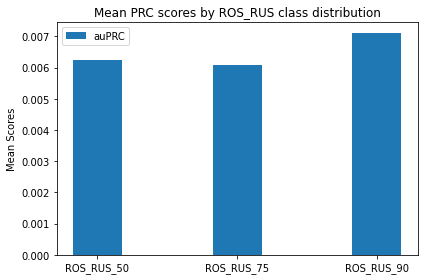

In [15]:
import matplotlib.pyplot as plt
import numpy as np


labels = results.keys()
auPRC_vals = [scores[0] for scores in results.values()]
auROC_vals = [scores[1] for scores in results.values()]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, auPRC_vals, width, label='auPRC')
#rects2 = ax.bar(x + width/2, auROC_vals, width, label='auROC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean Scores')
ax.set_title('Mean PRC scores by ROS_RUS class distribution')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

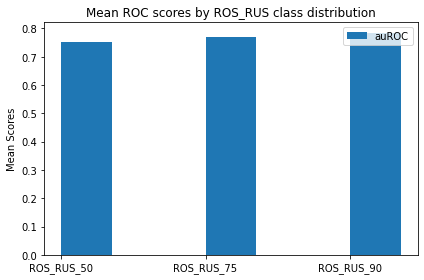

In [16]:
fig, ax = plt.subplots()
#rects1 = ax.bar(x, auPRC_vals, width, label='auPRC')
rects2 = ax.bar(x + width/2, auROC_vals, width, label='auROC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean Scores')
ax.set_title('Mean ROC scores by ROS_RUS class distribution')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()